In [23]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
from scipy import stats
import xarray as xr
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
az.style.use('arviz-doc')


In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

<center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Generalizando modelos lineales</h1>



<br>
<br>
<br>
<br>
<br>

## Objetivos

* Introducir el concepto de modelo lineal
* Explorar la flexibilidad de los modelos lineales

## Regresión polinomial

<br>

* Cuando nos referimos a que un modelo es lineal, nos referimos a que es lineal en los parámetros

$$\mu = \beta_0 x^0 + \beta_1 x^1  \dots + \beta_m x^m$$


* Si prestamos atención, podemos ver que este polinomio _esconde_  un modelo lineal simple. De hecho si hacemos que $\beta_n = 0$ para $n \gt 1$ obtendremos:

$$\mu = \beta_0 + \beta_1 x$$


* Probemos ajustar un conjunto de datos usando una regresión polinomial de grado 2.

$$\mu = \beta_0 + \beta_1 x + \beta_2 x^2$$

In [5]:
ans = pd.read_csv('../datos/anscombe.csv')
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0);

In [7]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sigma=1)
    β1 = pm.Normal('β1', mu=0, sigma=1)
    β2 = pm.Normal('β2', mu=0, sigma=1)
    ϵ = pm.HalfNormal('ϵ', 10)

    mu = α + β1 * x_2 + β2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sigma=ϵ, observed=y_2)
    
    idata_poly = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, ϵ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


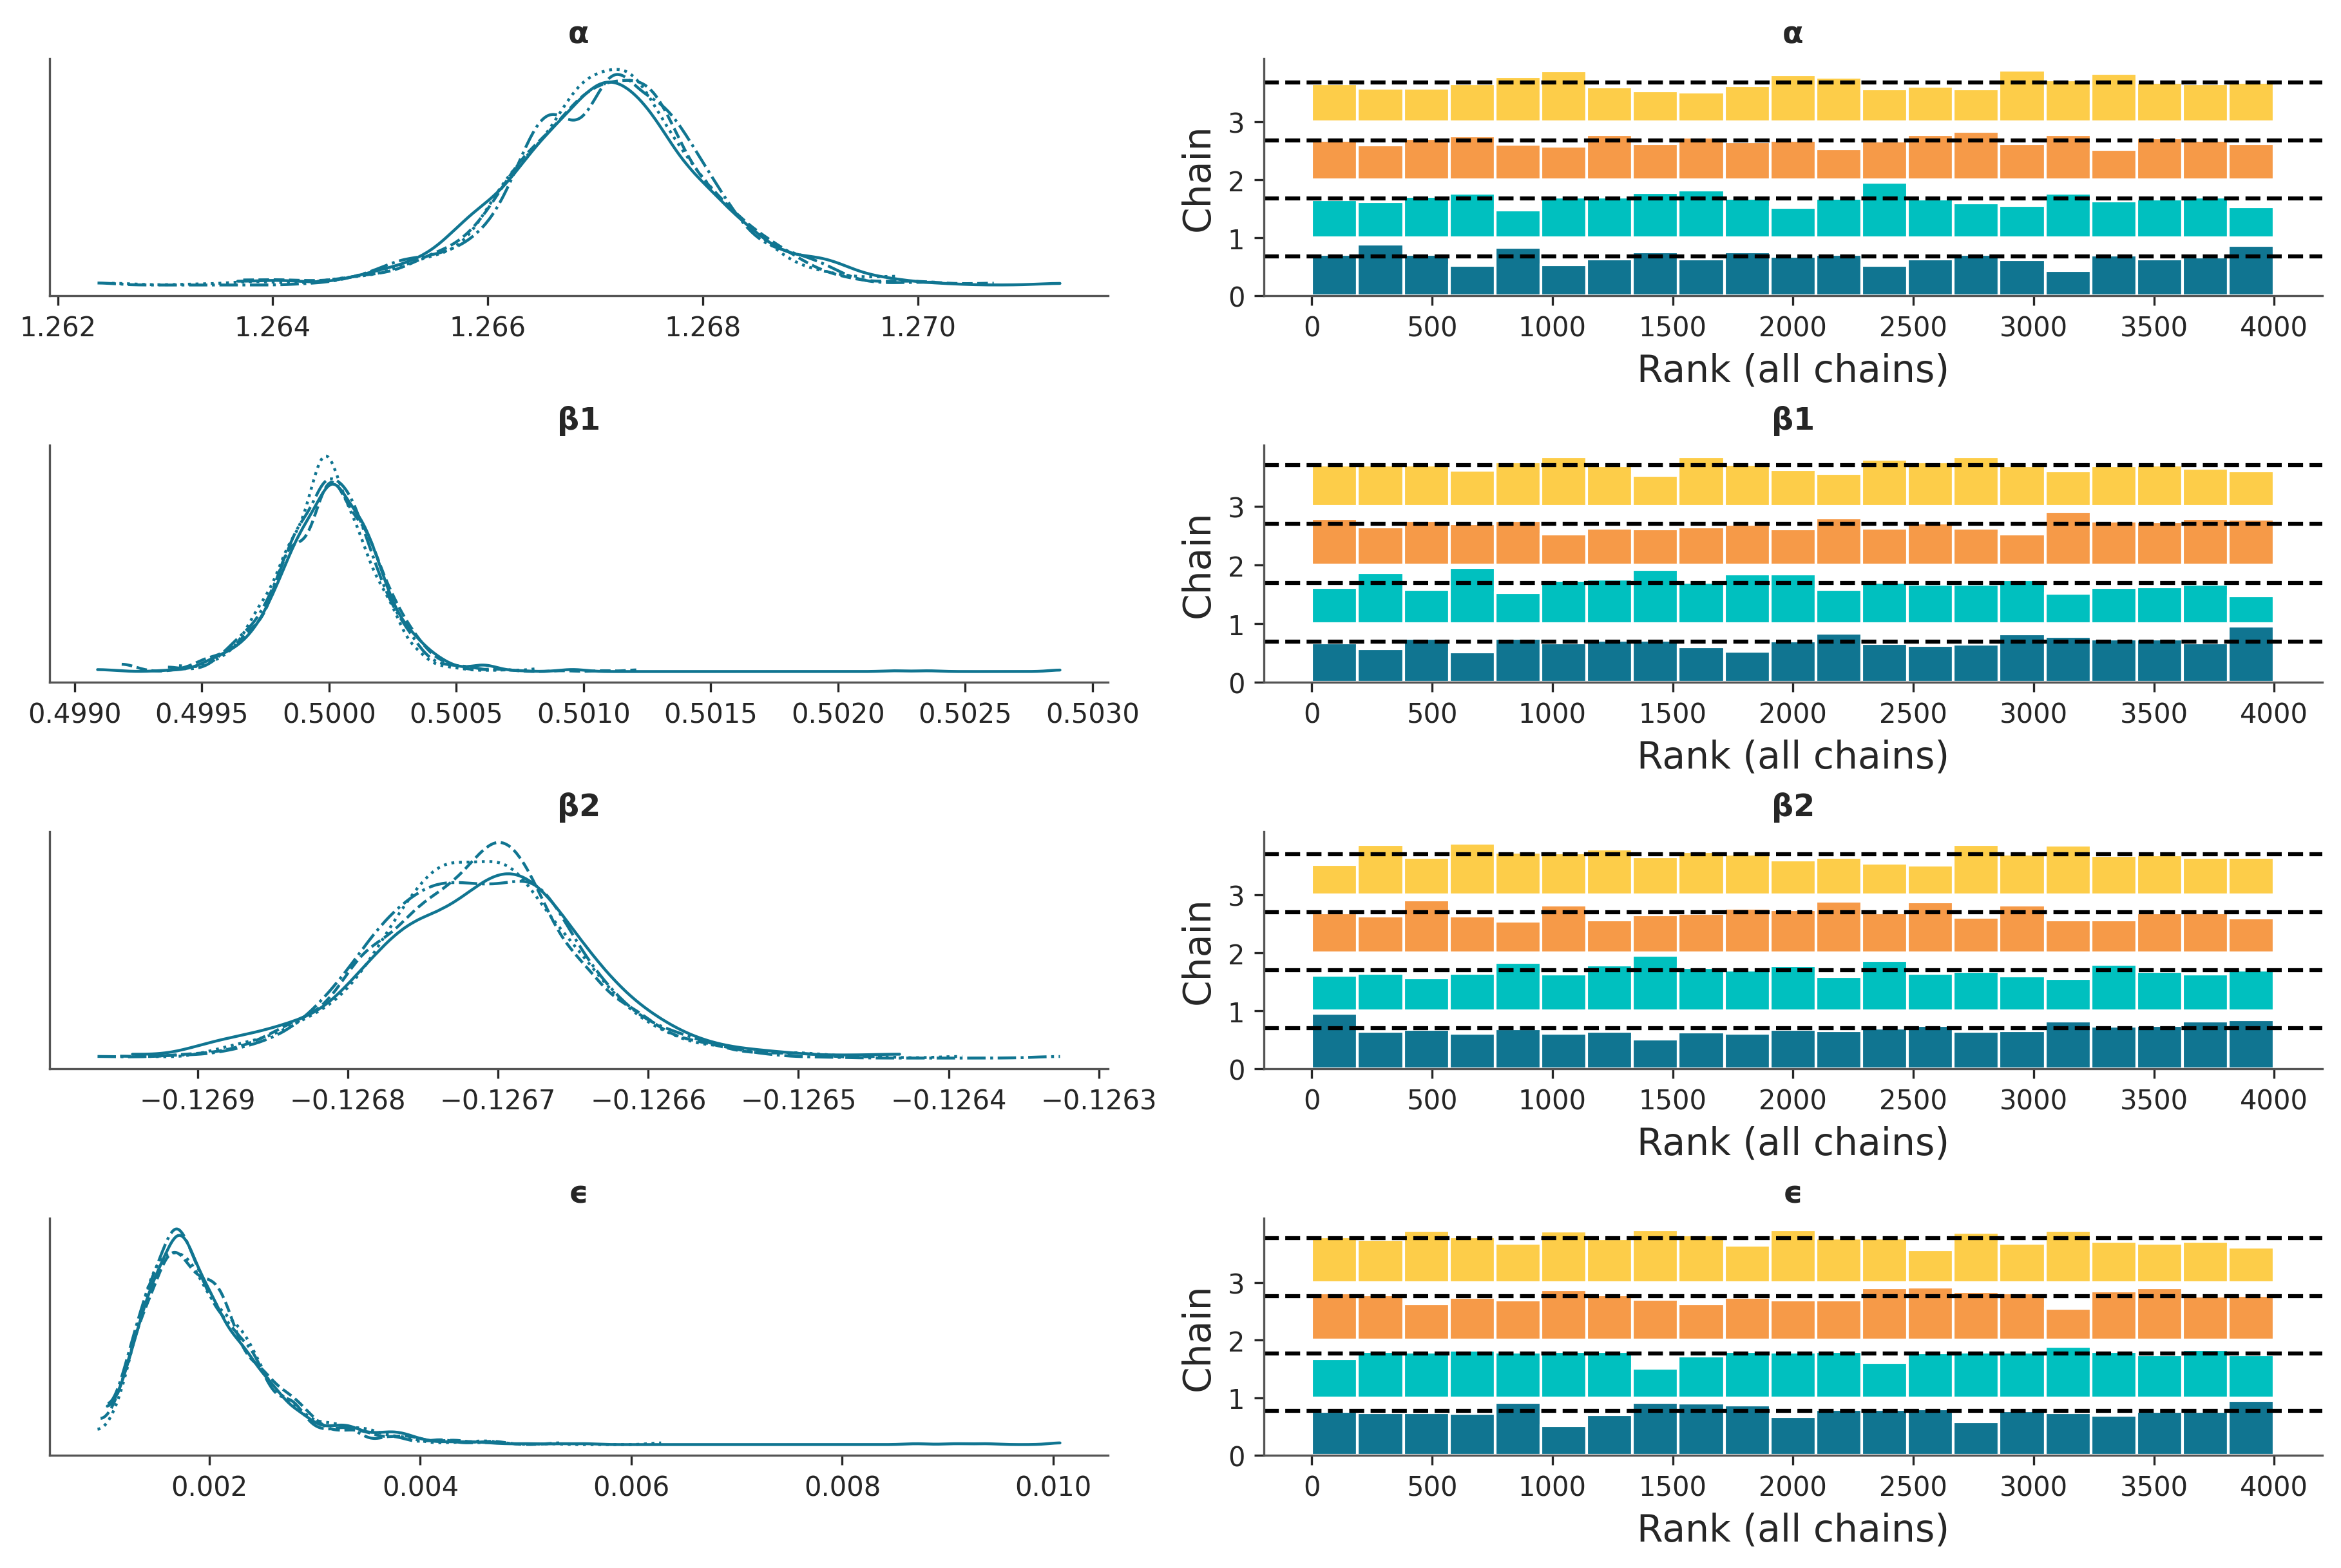

In [13]:
az.plot_trace(idata_poly, kind="rank_bars");

In [15]:
az.summary(idata_poly)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.267,0.001,1.265,1.269,0.0,0.0,2243.0,1900.0,1.0
β1,0.500,0.000,0.500,0.500,0.0,0.0,2589.0,1984.0,1.0
β2,-0.127,0.000,-0.127,-0.127,0.0,0.0,2137.0,1875.0,1.0
ϵ,0.002,0.001,0.001,0.003,0.0,0.0,1364.0,1932.0,1.0


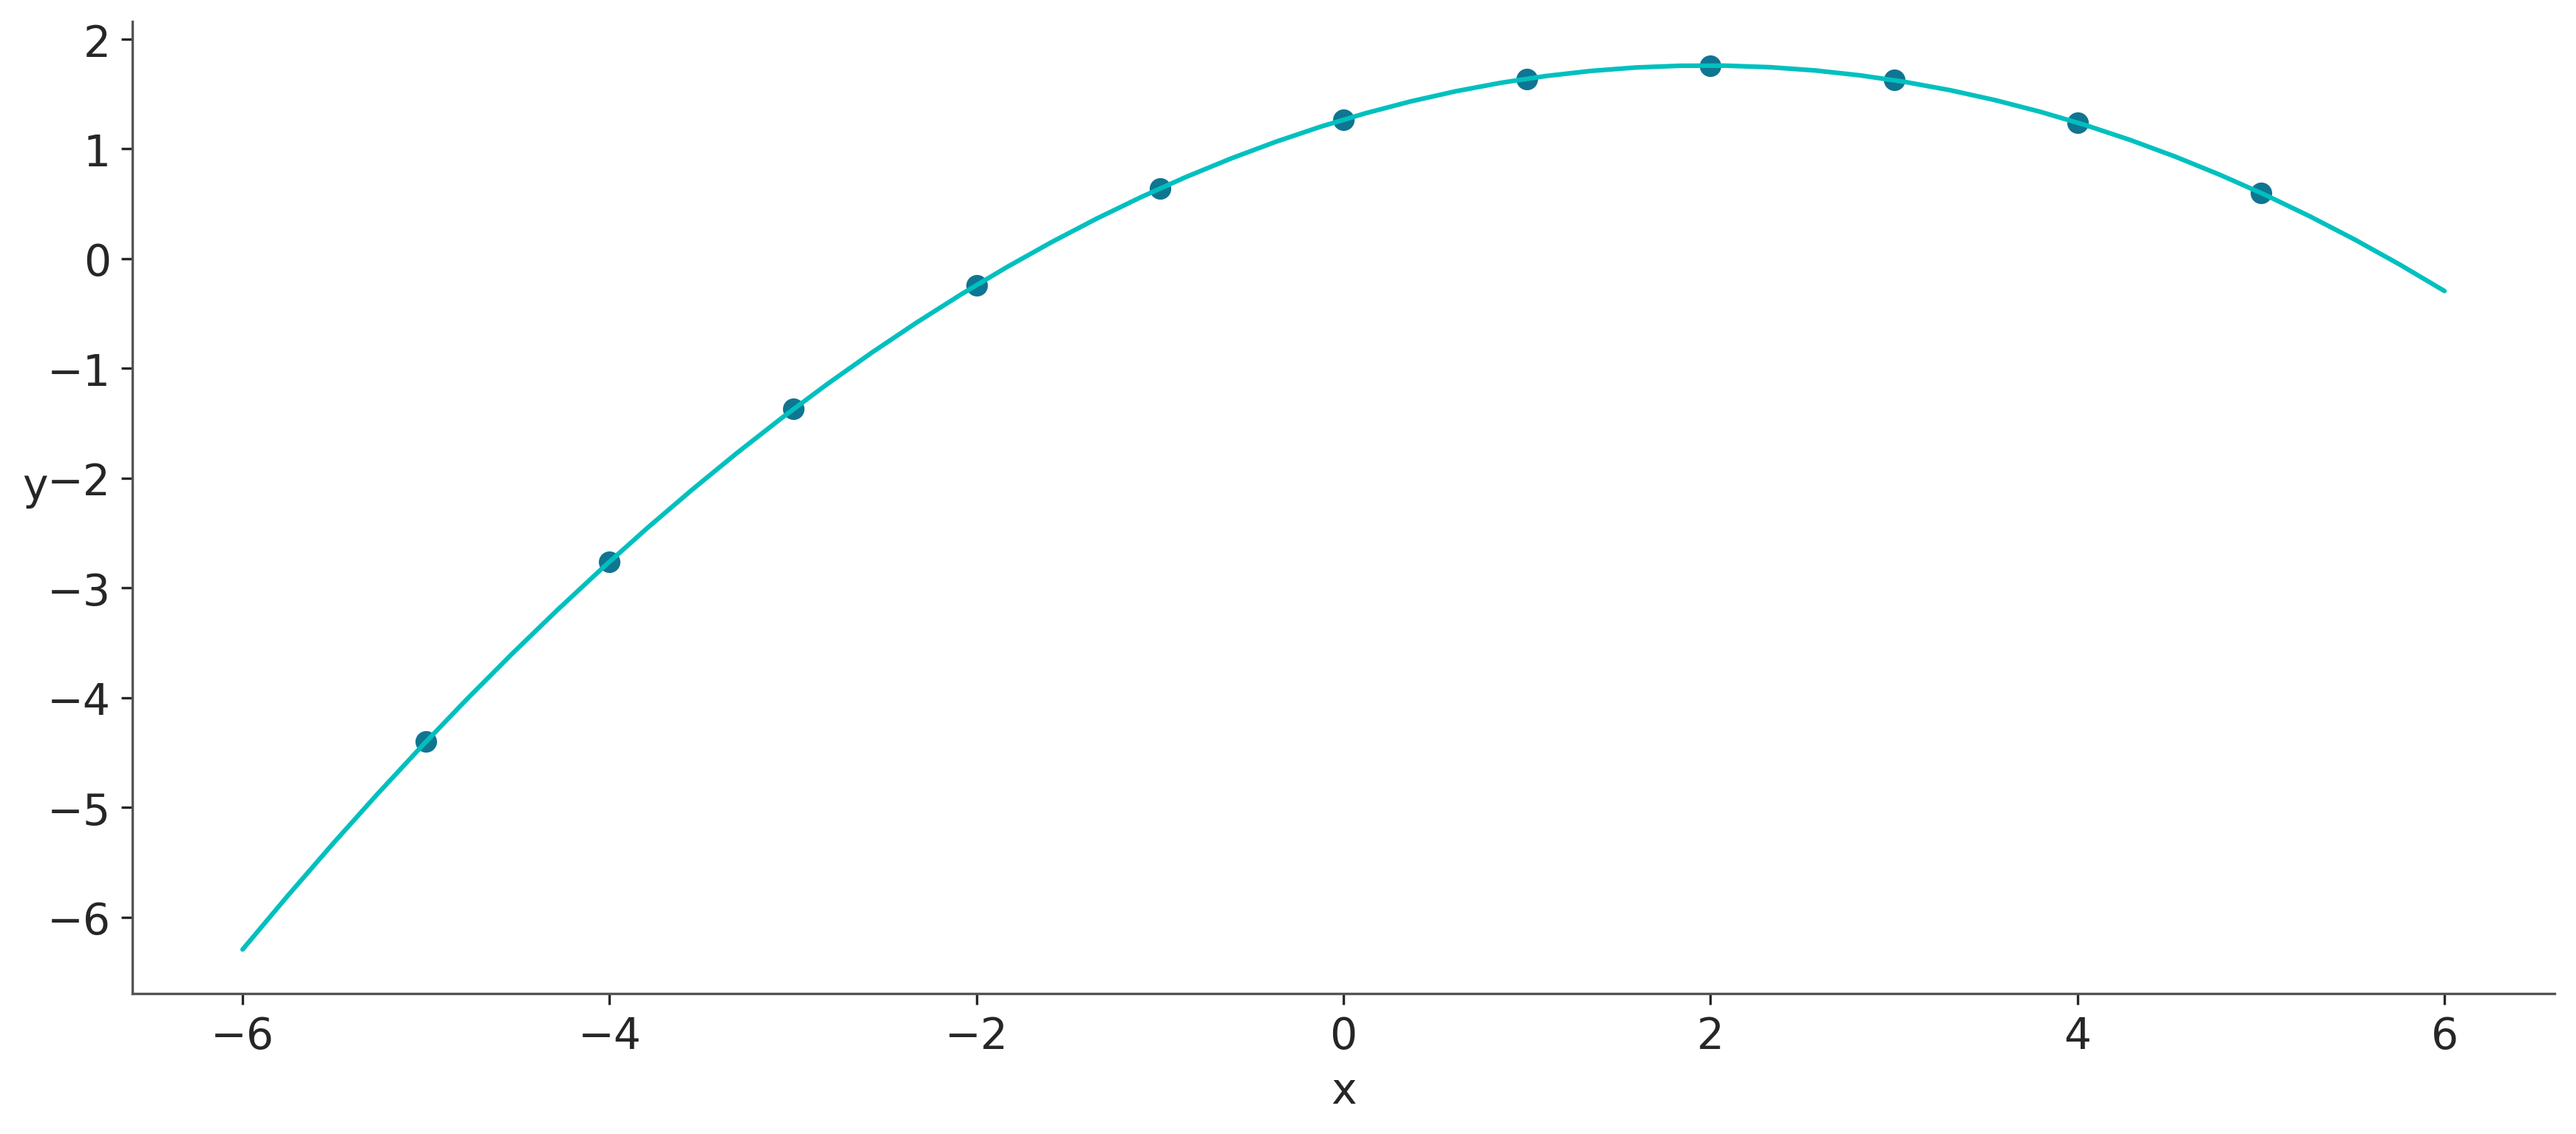

In [18]:
x_p = np.linspace(-6, 6)
post_mean = idata_poly.posterior.mean(("chain", "draw"))

y_p = post_mean['α'].item() + post_mean['β1'].item() * x_p + post_mean['β2'].item() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x',)
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

## Varianza variable y transformaciones

<br>

* Hemos estado usando el modelo lineal para modelar la media de una distribución, dejando la varianza de lado. 


* En caso que consideremos que el supuesto de varianza constante no tiene sentido, una posibilidad es considerar la varianza como una función (lineal) de la variable dependiente.



* La Organización Mundial de la Salud y otras instituciones de salud de todo el mundo recopilan datos para recién nacidos


* Un ejemplo son la longitud (alturas) de las niñas recién nacidas en función de la edad (en meses):

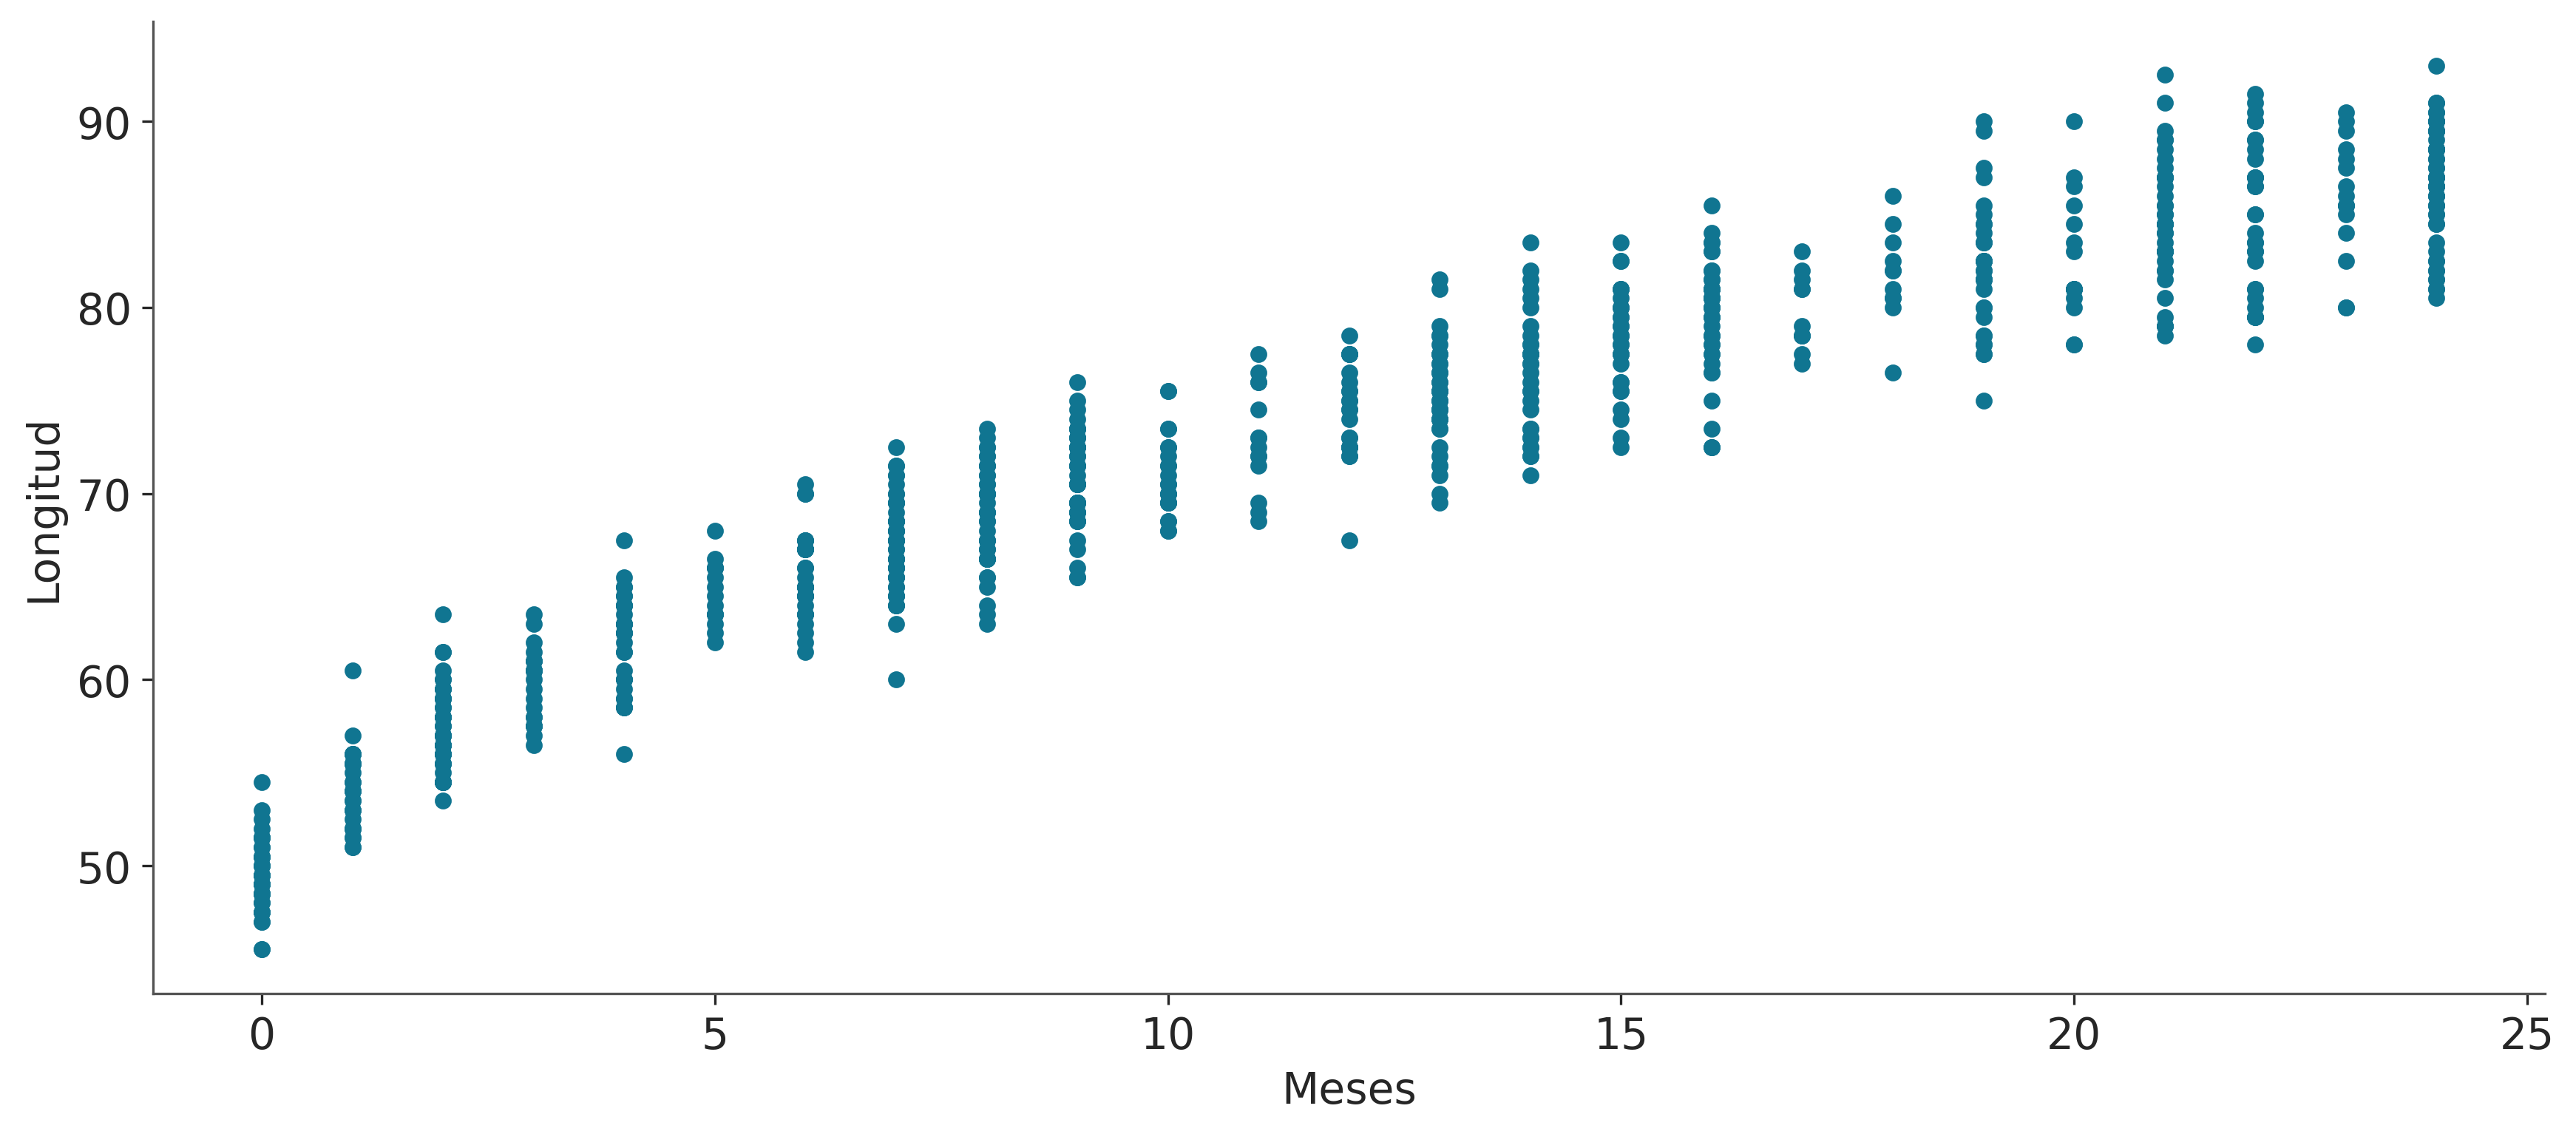

In [22]:
data = pd.read_csv('../datos/babies.csv')
data.plot.scatter('Meses', 'Longitud');

Para modelar estos datos, presentaremos 3 elementos nuevos en comparación con los modelos anteriores:

<br>


* $\epsilon$ ahora es una función lineal de $X$, y para hacer esto agregaremos dos nuevos parámetros $\gamma$ y $\delta$, estos son análogos directos de $\alpha$ y $\beta$.


* El modelo lineal para la media es una función de $\sqrt{X}$, esto es solo un _truco_ para ajustar una curva usando un modelo lineal


* Vamos a definir una variable "x_shared" usando la función `pm.MutableData()`. Esto nos permitirá cambiar los valores de la variable aleatoria `Meses` sin la necesidad de volver a correr el modelo. 

In [23]:
with pm.Model() as model_vv:
    x_shared = pm.MutableData("x_shared", data.Meses.values * 1.)
    α = pm.Normal('α', sigma=10)
    β = pm.Normal('β', sigma=10)
    γ = pm.HalfNormal('γ', sigma=10)
    δ = pm.HalfNormal('δ', sigma=10)


    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=data.Longitud)
    
    idata_vv = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


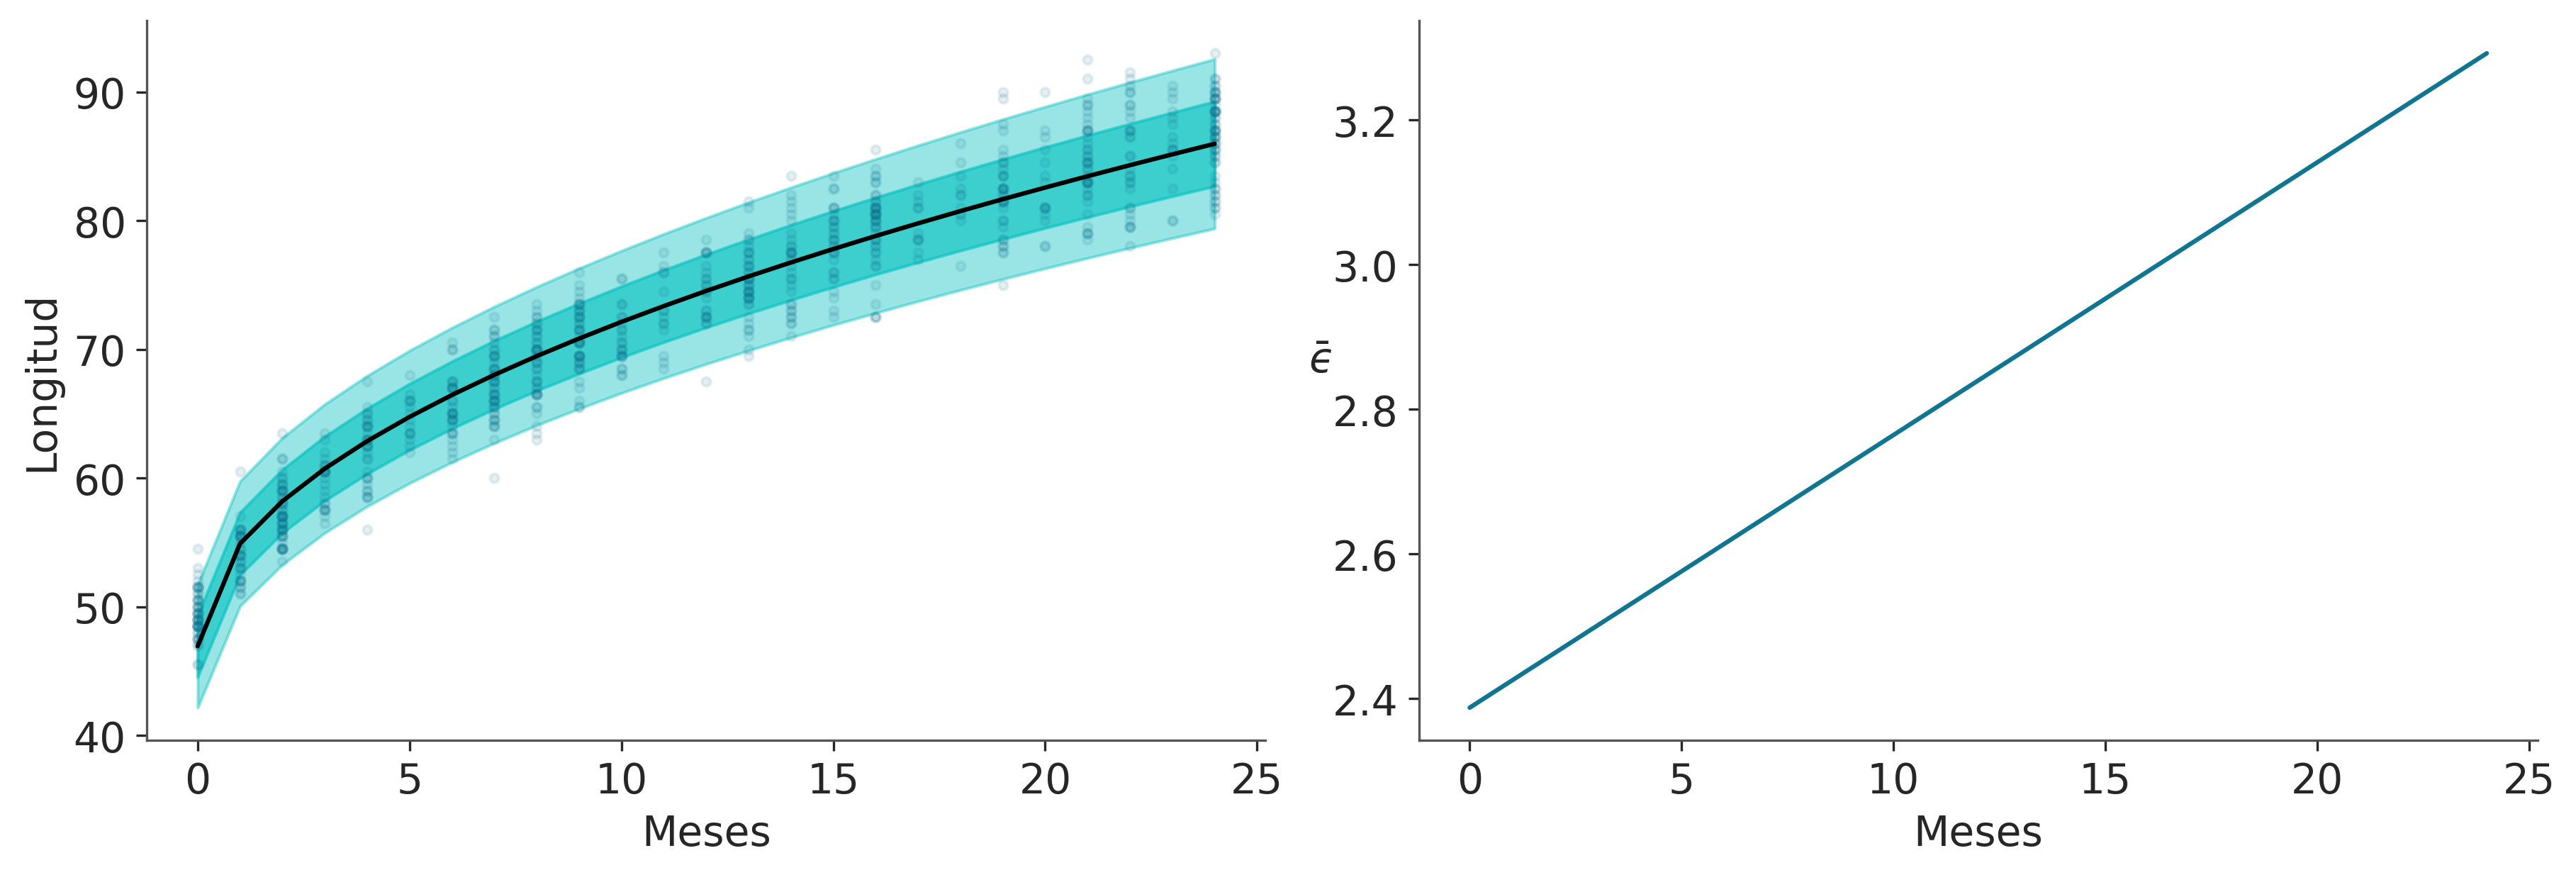

In [24]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(data.Meses, data.Longitud, 'C0.', alpha=0.1);

posterior = az.extract(idata_vv)

μ_m = posterior['μ'].mean("sample").values
ϵ_m = posterior['ϵ'].mean("sample").values

axes[0].plot(data.Meses, μ_m, c='k')
axes[0].fill_between(data.Meses, μ_m + 1 * ϵ_m, μ_m - 1 * ϵ_m, alpha=0.6, color='C1')
axes[0].fill_between(data.Meses, μ_m + 2 * ϵ_m, μ_m - 2 * ϵ_m, alpha=0.4, color='C1')

axes[0].set_xlabel('Meses')
axes[0].set_ylabel('Longitud');


axes[1].plot(data.Meses, ϵ_m)
axes[1].set_xlabel('Meses');
axes[1].set_ylabel(r'$\bar ϵ$', rotation=0);

* PyMC permite generar datos  $\tilde Y$ a partir del modelo ajustado usando la función `pm.sample_posterior_predictive()`.


* Por defecto, en una regresión, estas muestras $\tilde Y$ serán evaluadas para los valores observados de 'X' (predicciones dentro de la muestra o in sample predictions).


* Si queremos generar datos  $\tilde y$  para valores de $X$ no observados necesitamos actualizar el valor de la variable `x_shared` usando la función `pm.set_data()`, por esta razón es que en el modelo definimos a `x_shared` usando la función `pm.MutableData()`.

* Veamos cuales son los valores de $\tilde Y$ cuando $x=0.5$ (medio mes).

In [25]:
with model_vv:
    pm.set_data({"x_shared": [0.5]})
    ppc = pm.sample_posterior_predictive(idata_vv)
    y_ppc = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw"))

Sampling: [y_pred]


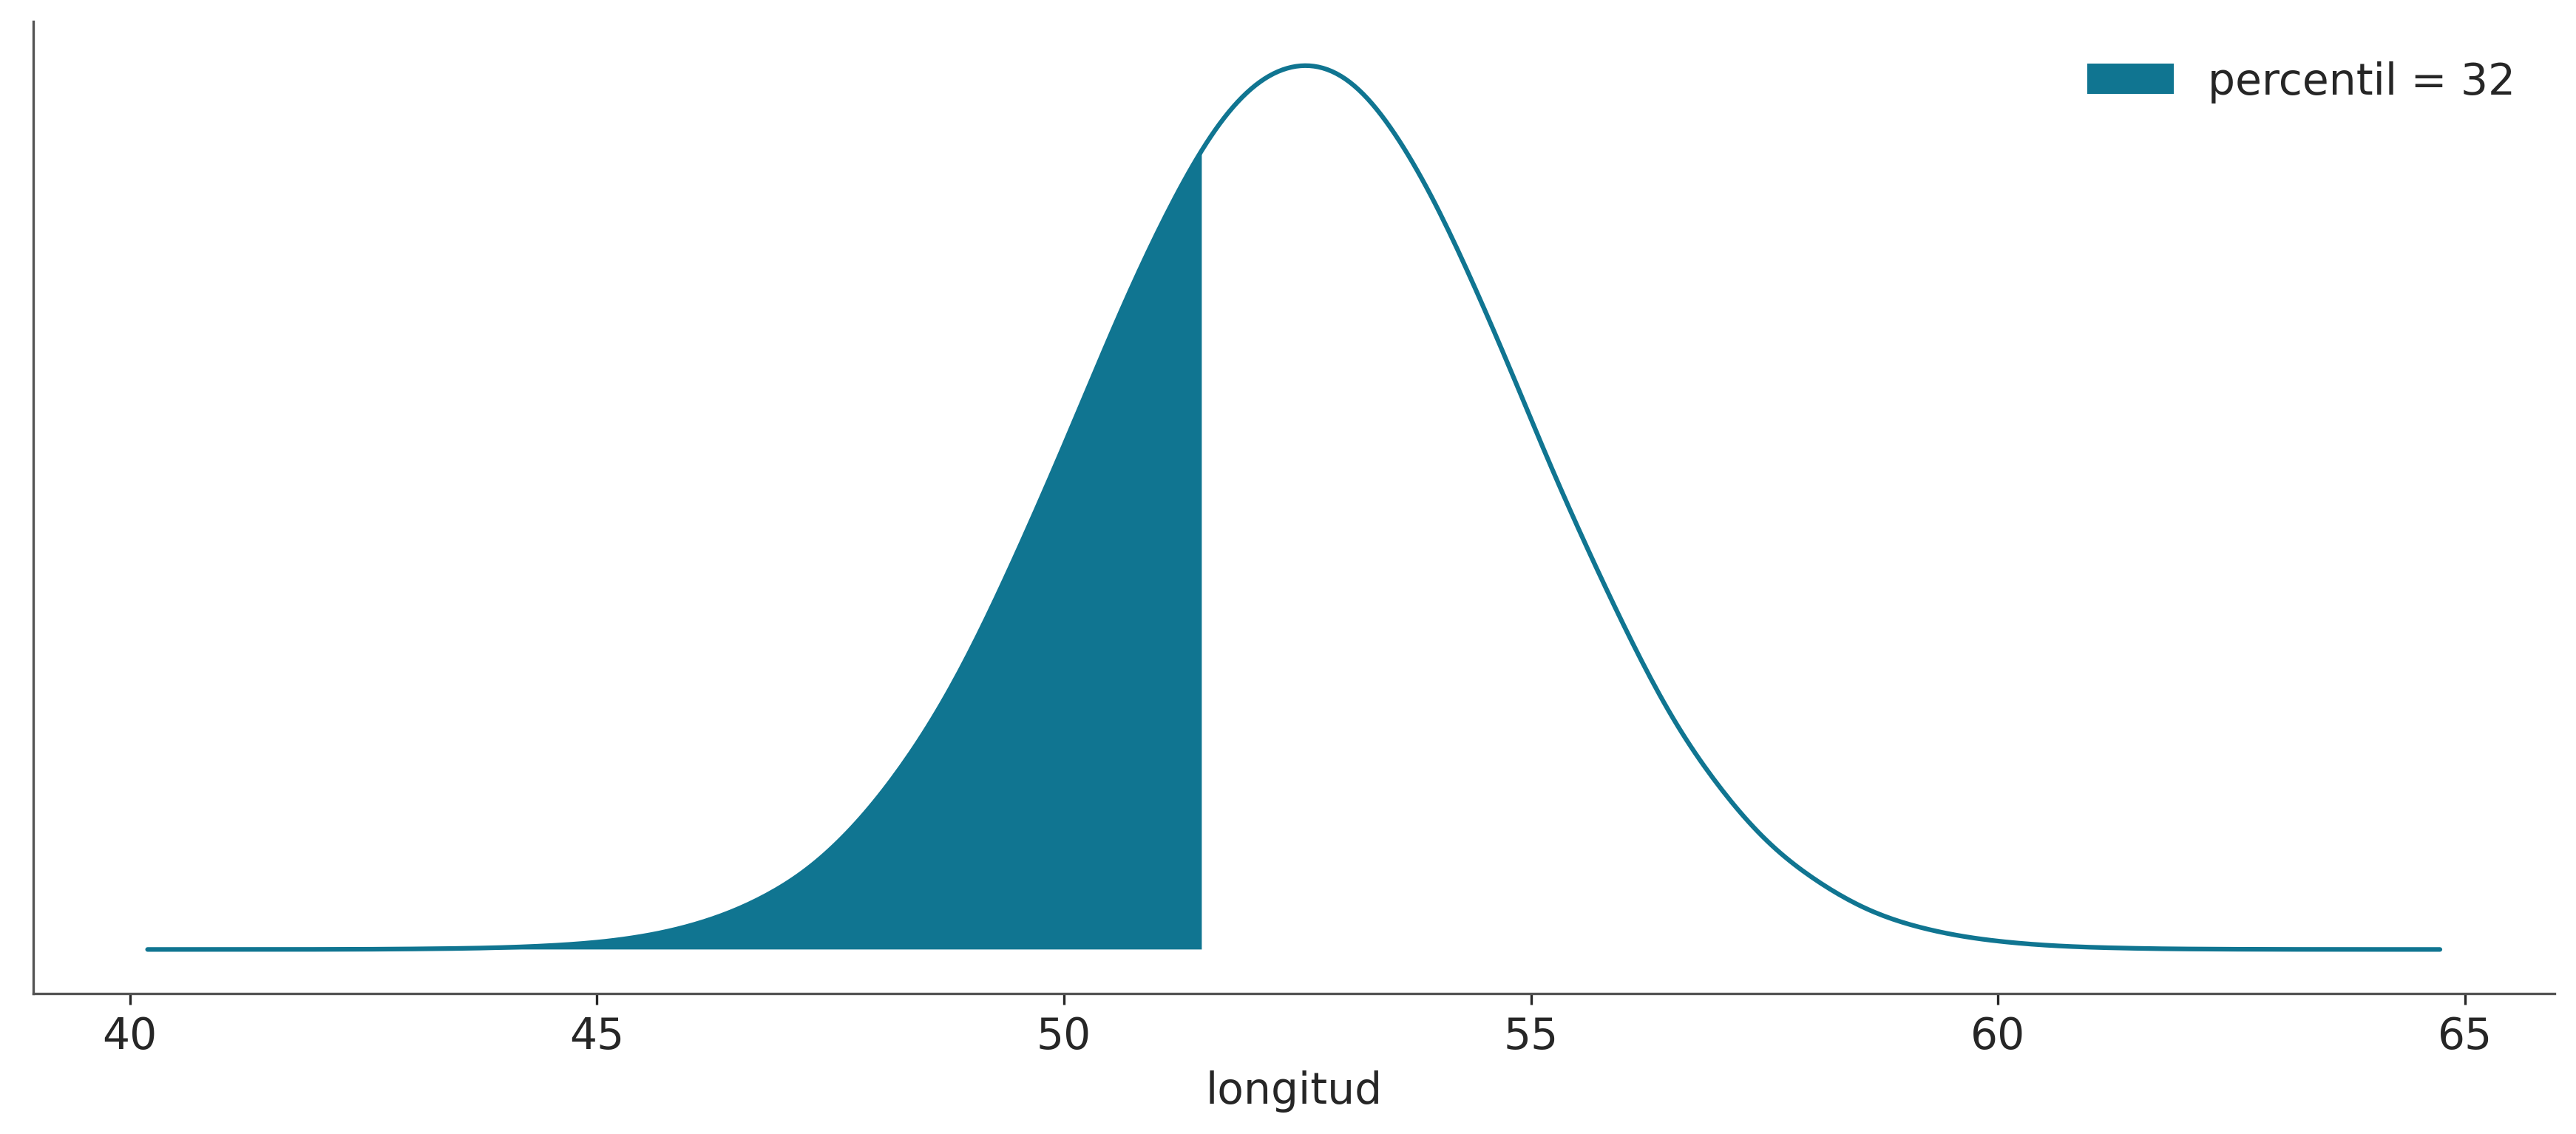

In [26]:
ref = 51.5
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(grid[grid < ref], pdf[grid < ref], label='percentil = {:2d}'.format(percentile))
plt.xlabel('longitud')
plt.yticks([])
plt.legend();

## Modelos lineales generalizados

Un modelo lineal generalizado tiene la siguiente forma


$$Y = \phi(f(\alpha + X \beta), \theta)$$

La regresion lineal que vimos anteriormente es un caso especial. 


$$Y = \mathcal{N}(\mu=\alpha + X \beta), \sigma=\theta)$$

* $f$ es la función inversa de enlace y tiene como objetivo permitir que los valores del modelo lineal, en general en $[-\infty, \infty]$
queden restringidos a un rango adecuado para ser parámetros de $\phi$

## Regresión logística

* La regresión logística es la generalización de la regresión lineal para cuando la variable dependiente sigue una distribución Bernoulli (o Binomial con n=1).


$$
\theta = \text{logística}(\alpha + X\beta) \\
Y = \text{Bern}(\theta) \tag{4.3} 
$$


* La función inversa de enlace es 

$$ \text{logística}(z) = \frac{1}{1 + e^{-z}} \tag{4.2}$$



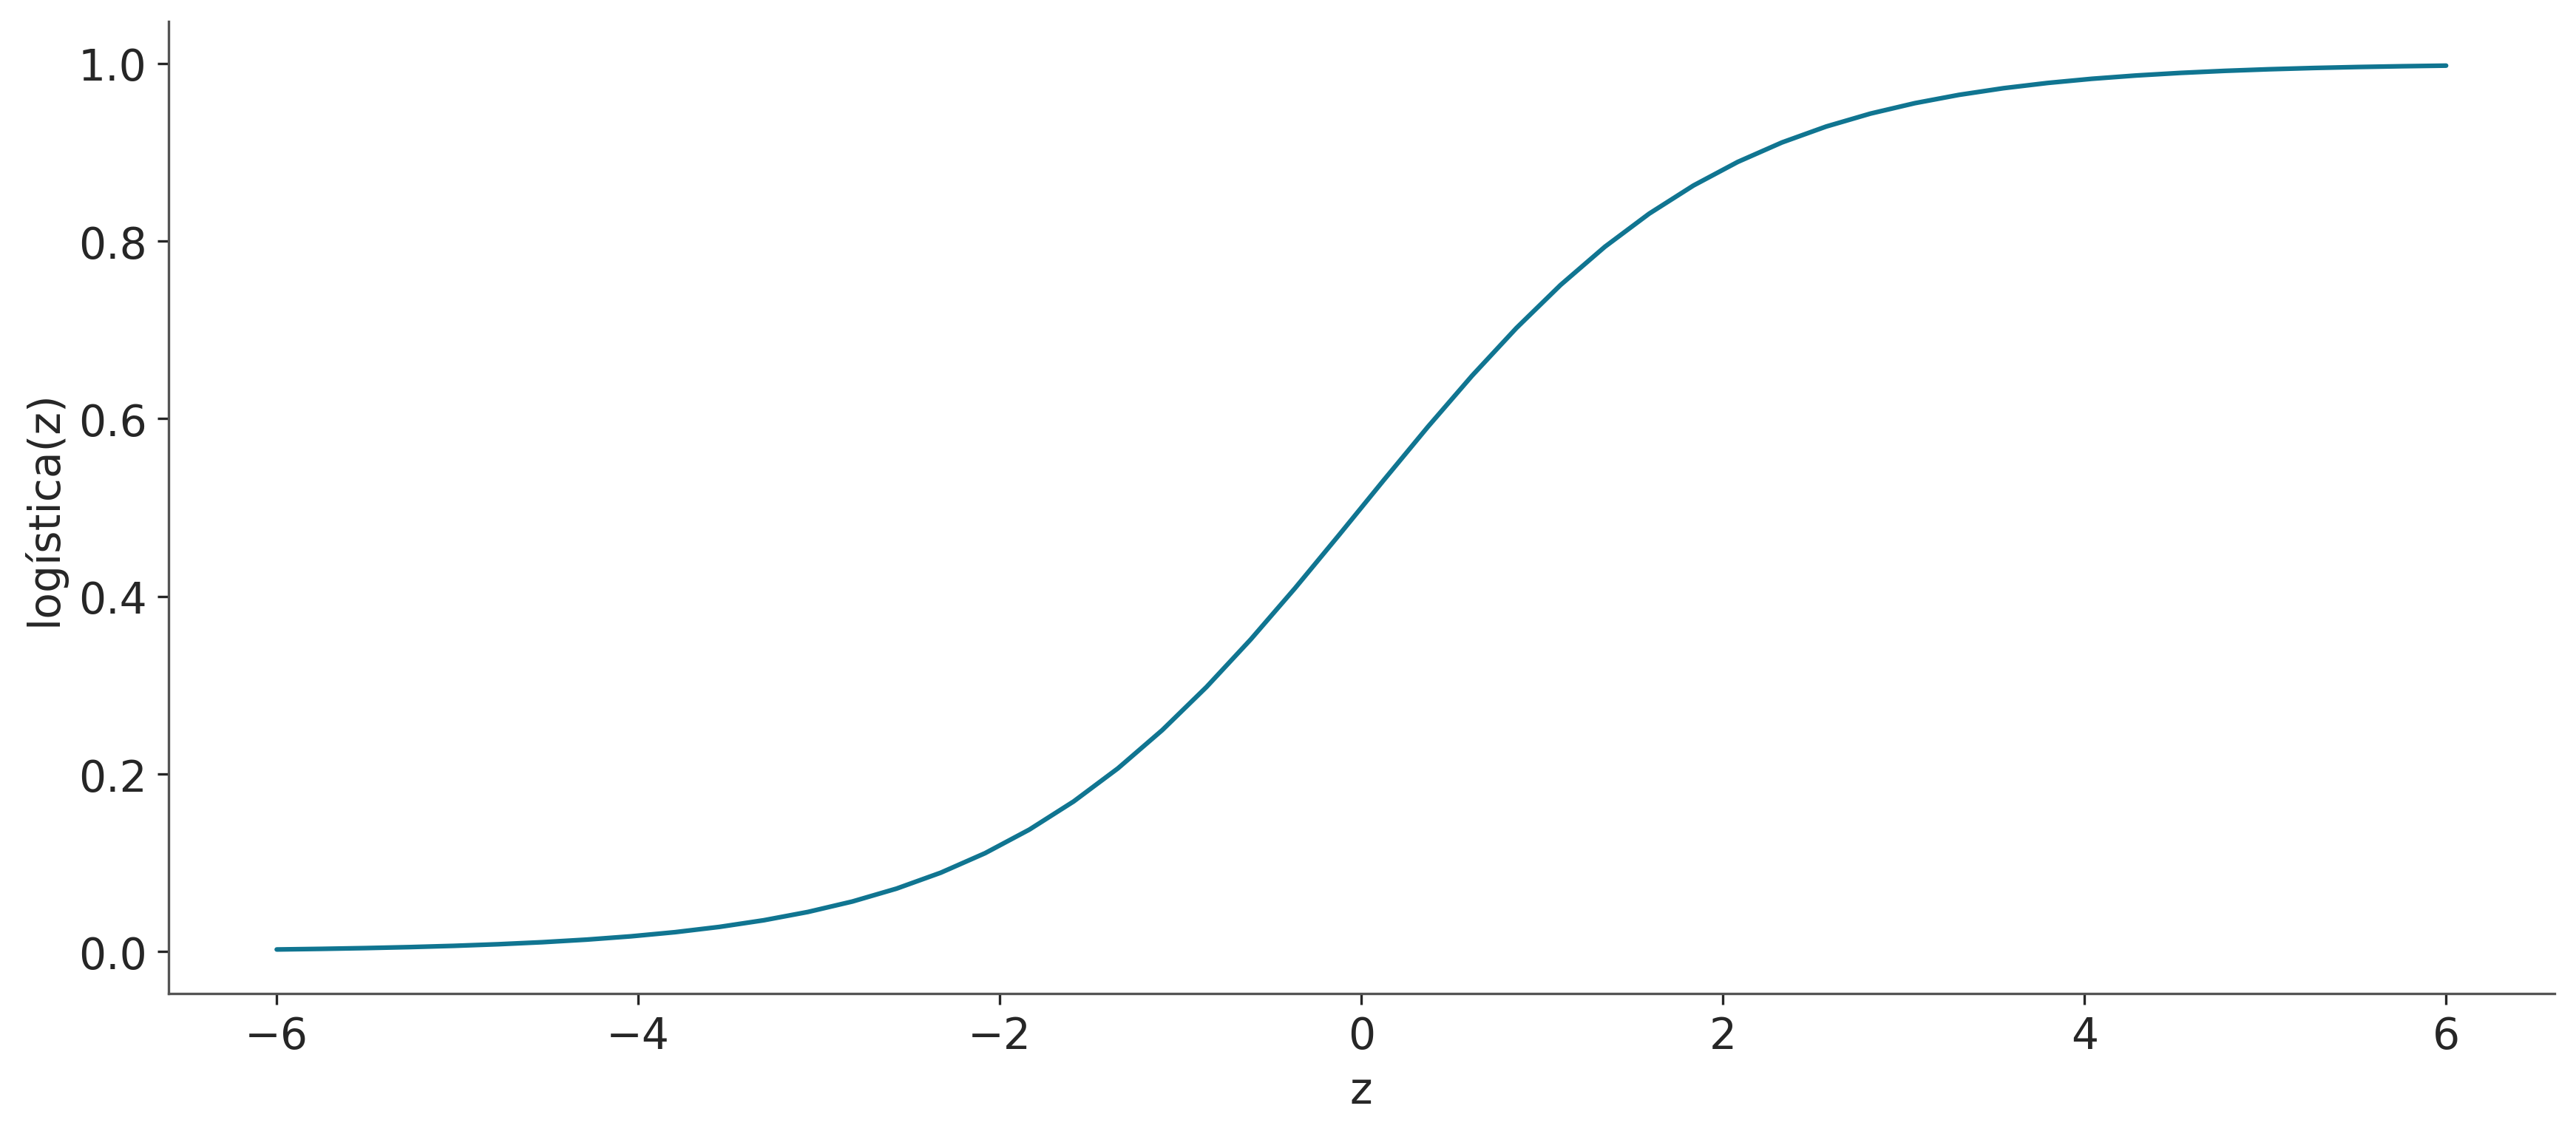

In [20]:
z = np.linspace(-6, 6)
logística = 1 / (1 + np.exp(-z))
plt.plot(z, logística)
plt.xlabel('z')
plt.ylabel('logística(z)');

## El conjunto de datos Iris


<br>


* Conjunto de datos clásico que contiene información sobre flores de 3 especies estrechamente relacionadas: setosa, virginica y versicolor. Estas serán nuestras variables dependientes. 


* Tenemos 50 individuos de cada especie 


* Para cada individuo contamos con cuatro variables (o _features_) que vamos a usar como variables independientes. El largo del pétalo, el ancho del pétalo, el largo del sépalo y el ancho del sépalo.

In [21]:
iris = pd.read_csv('../datos/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


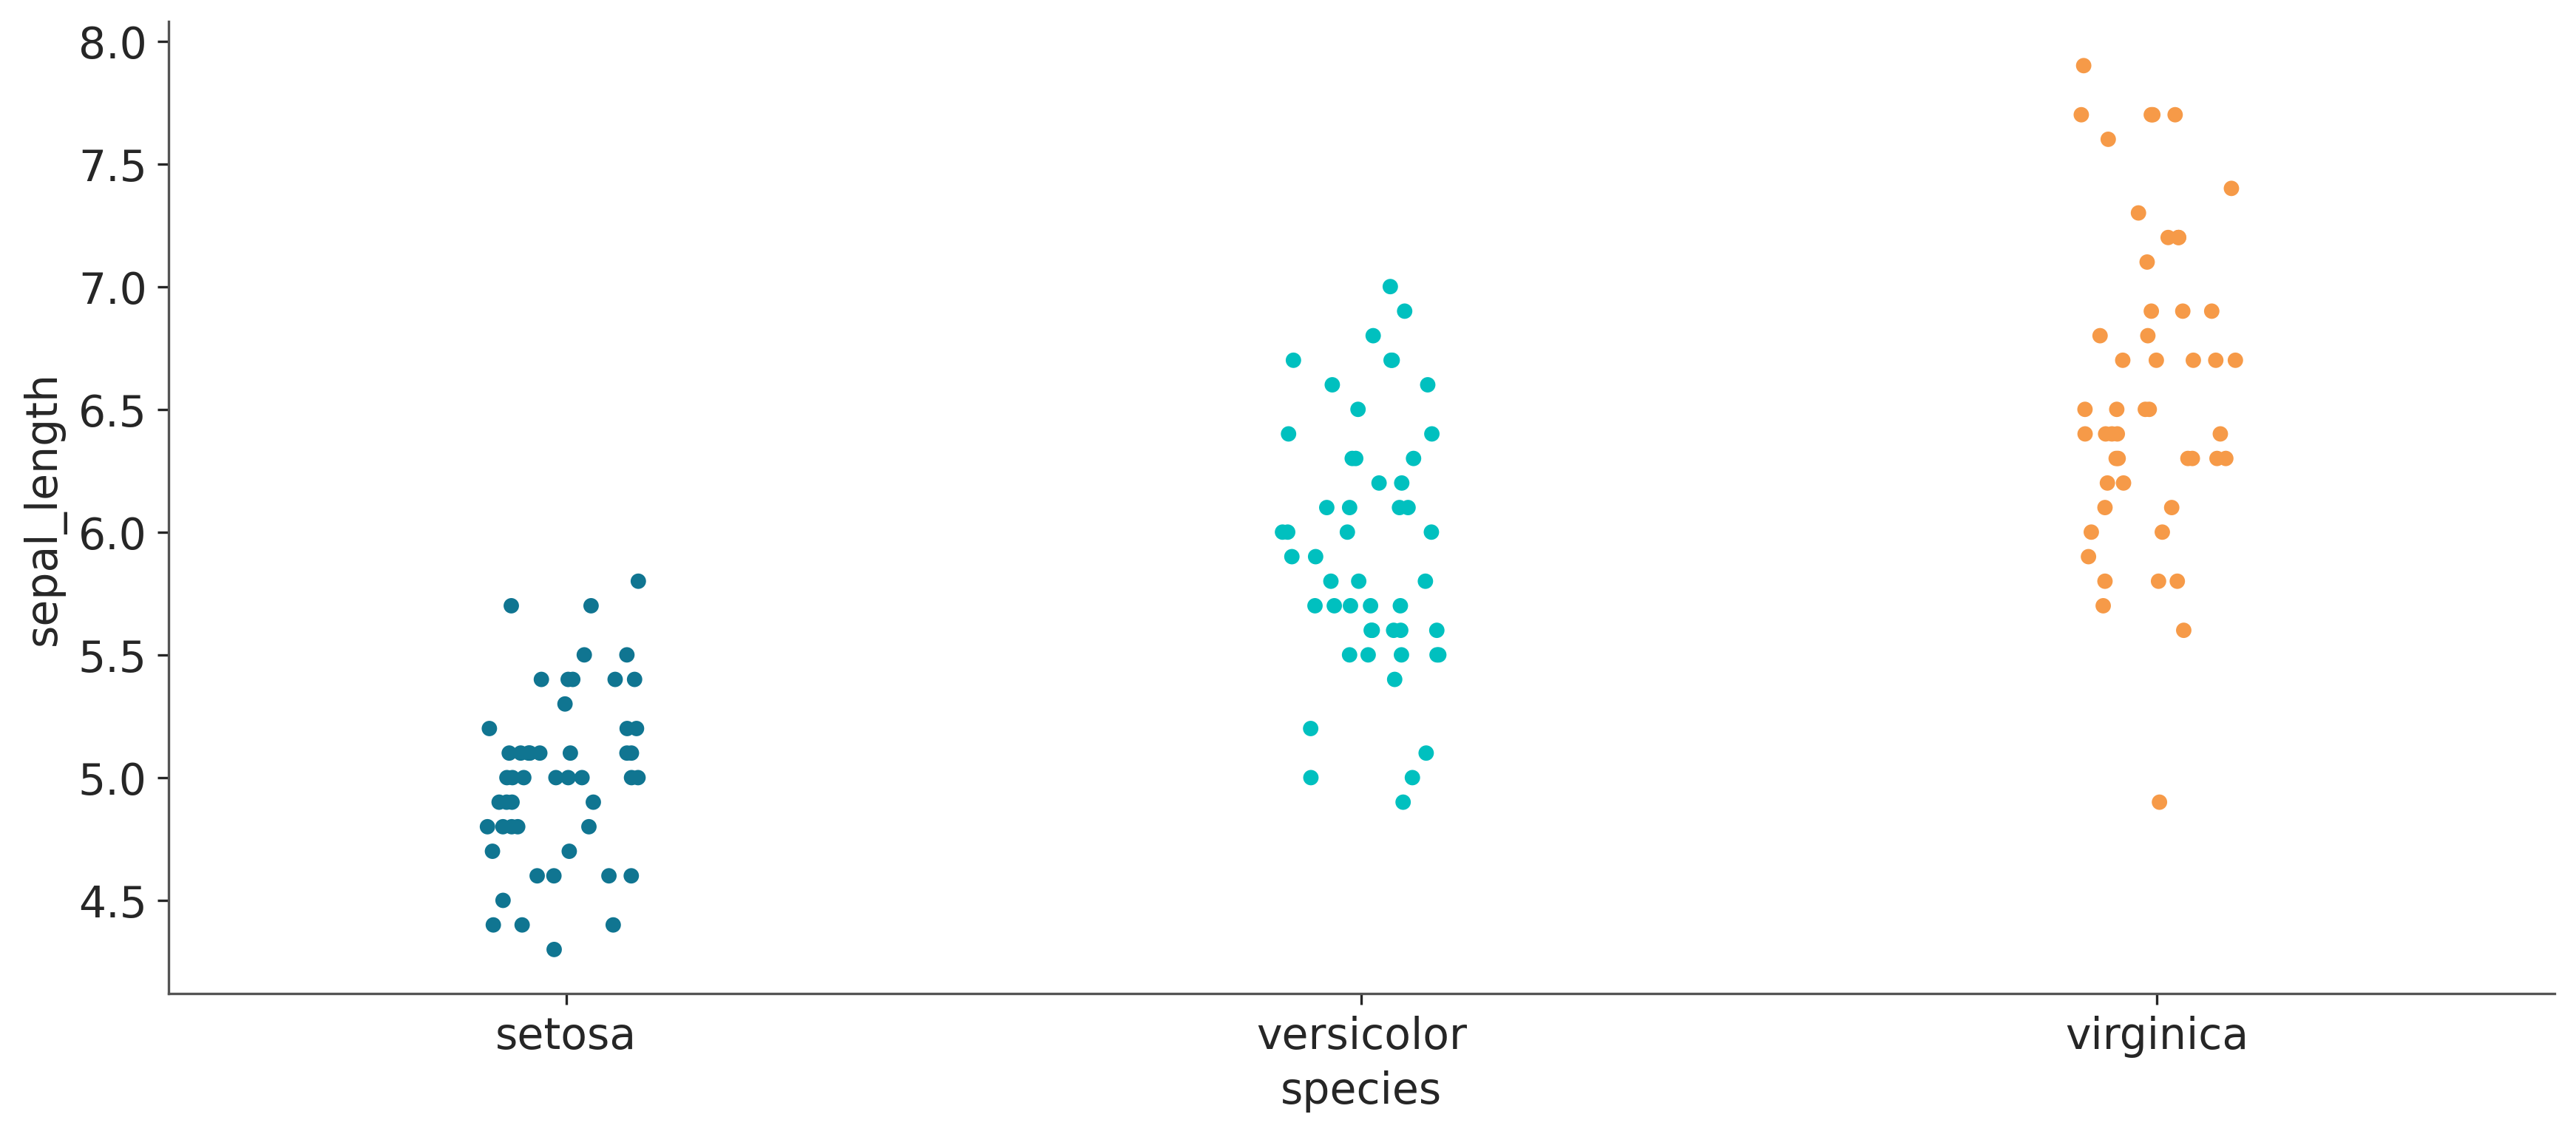

In [25]:
sns.stripplot(x="species", y="sepal_length", data=iris, hue="species", jitter=True, legend=False);

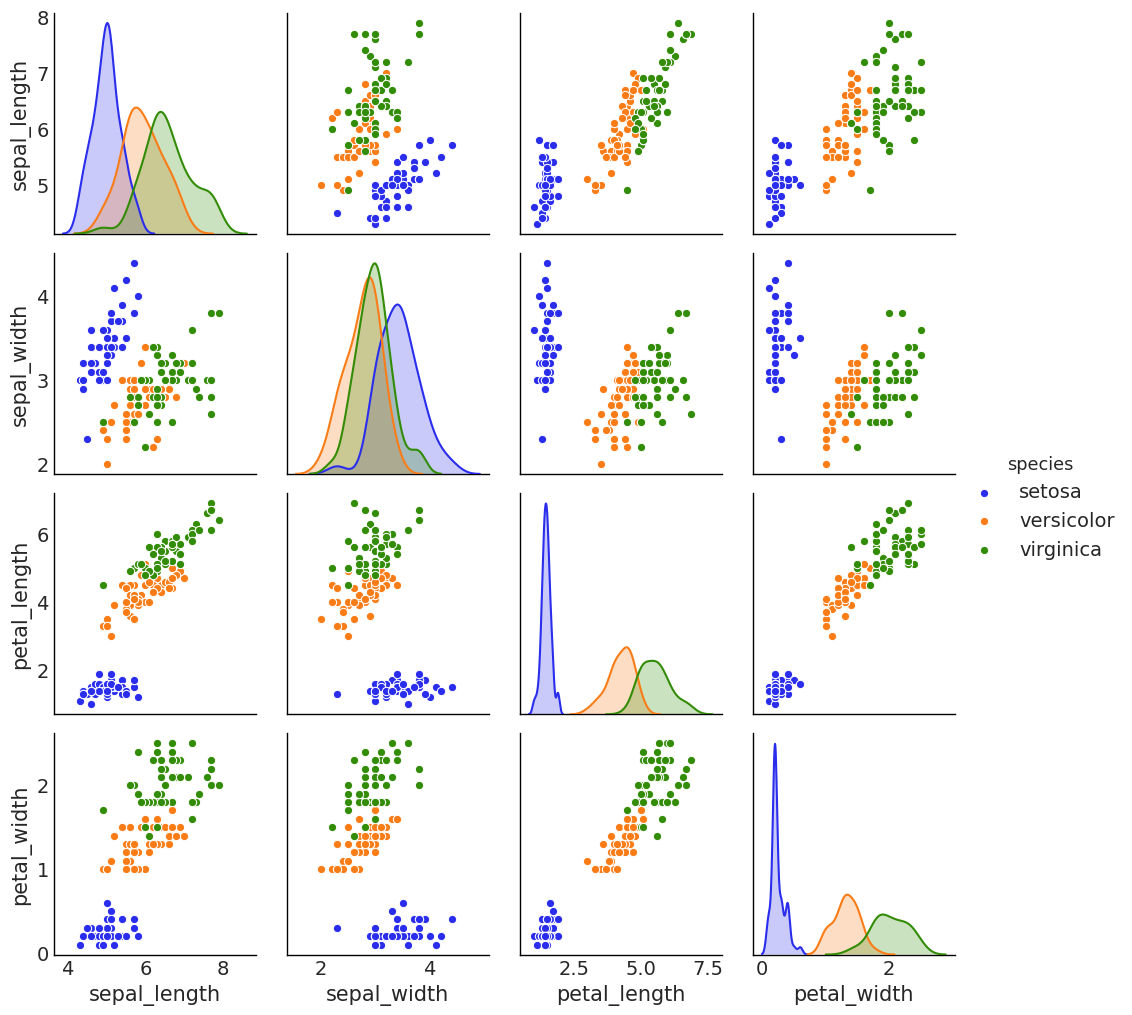

In [6]:
sns.pairplot(iris, hue='species', plot_kws={"legend":False});

In [26]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [27]:
with pm.Model() as modelo_0:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    trace_0 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


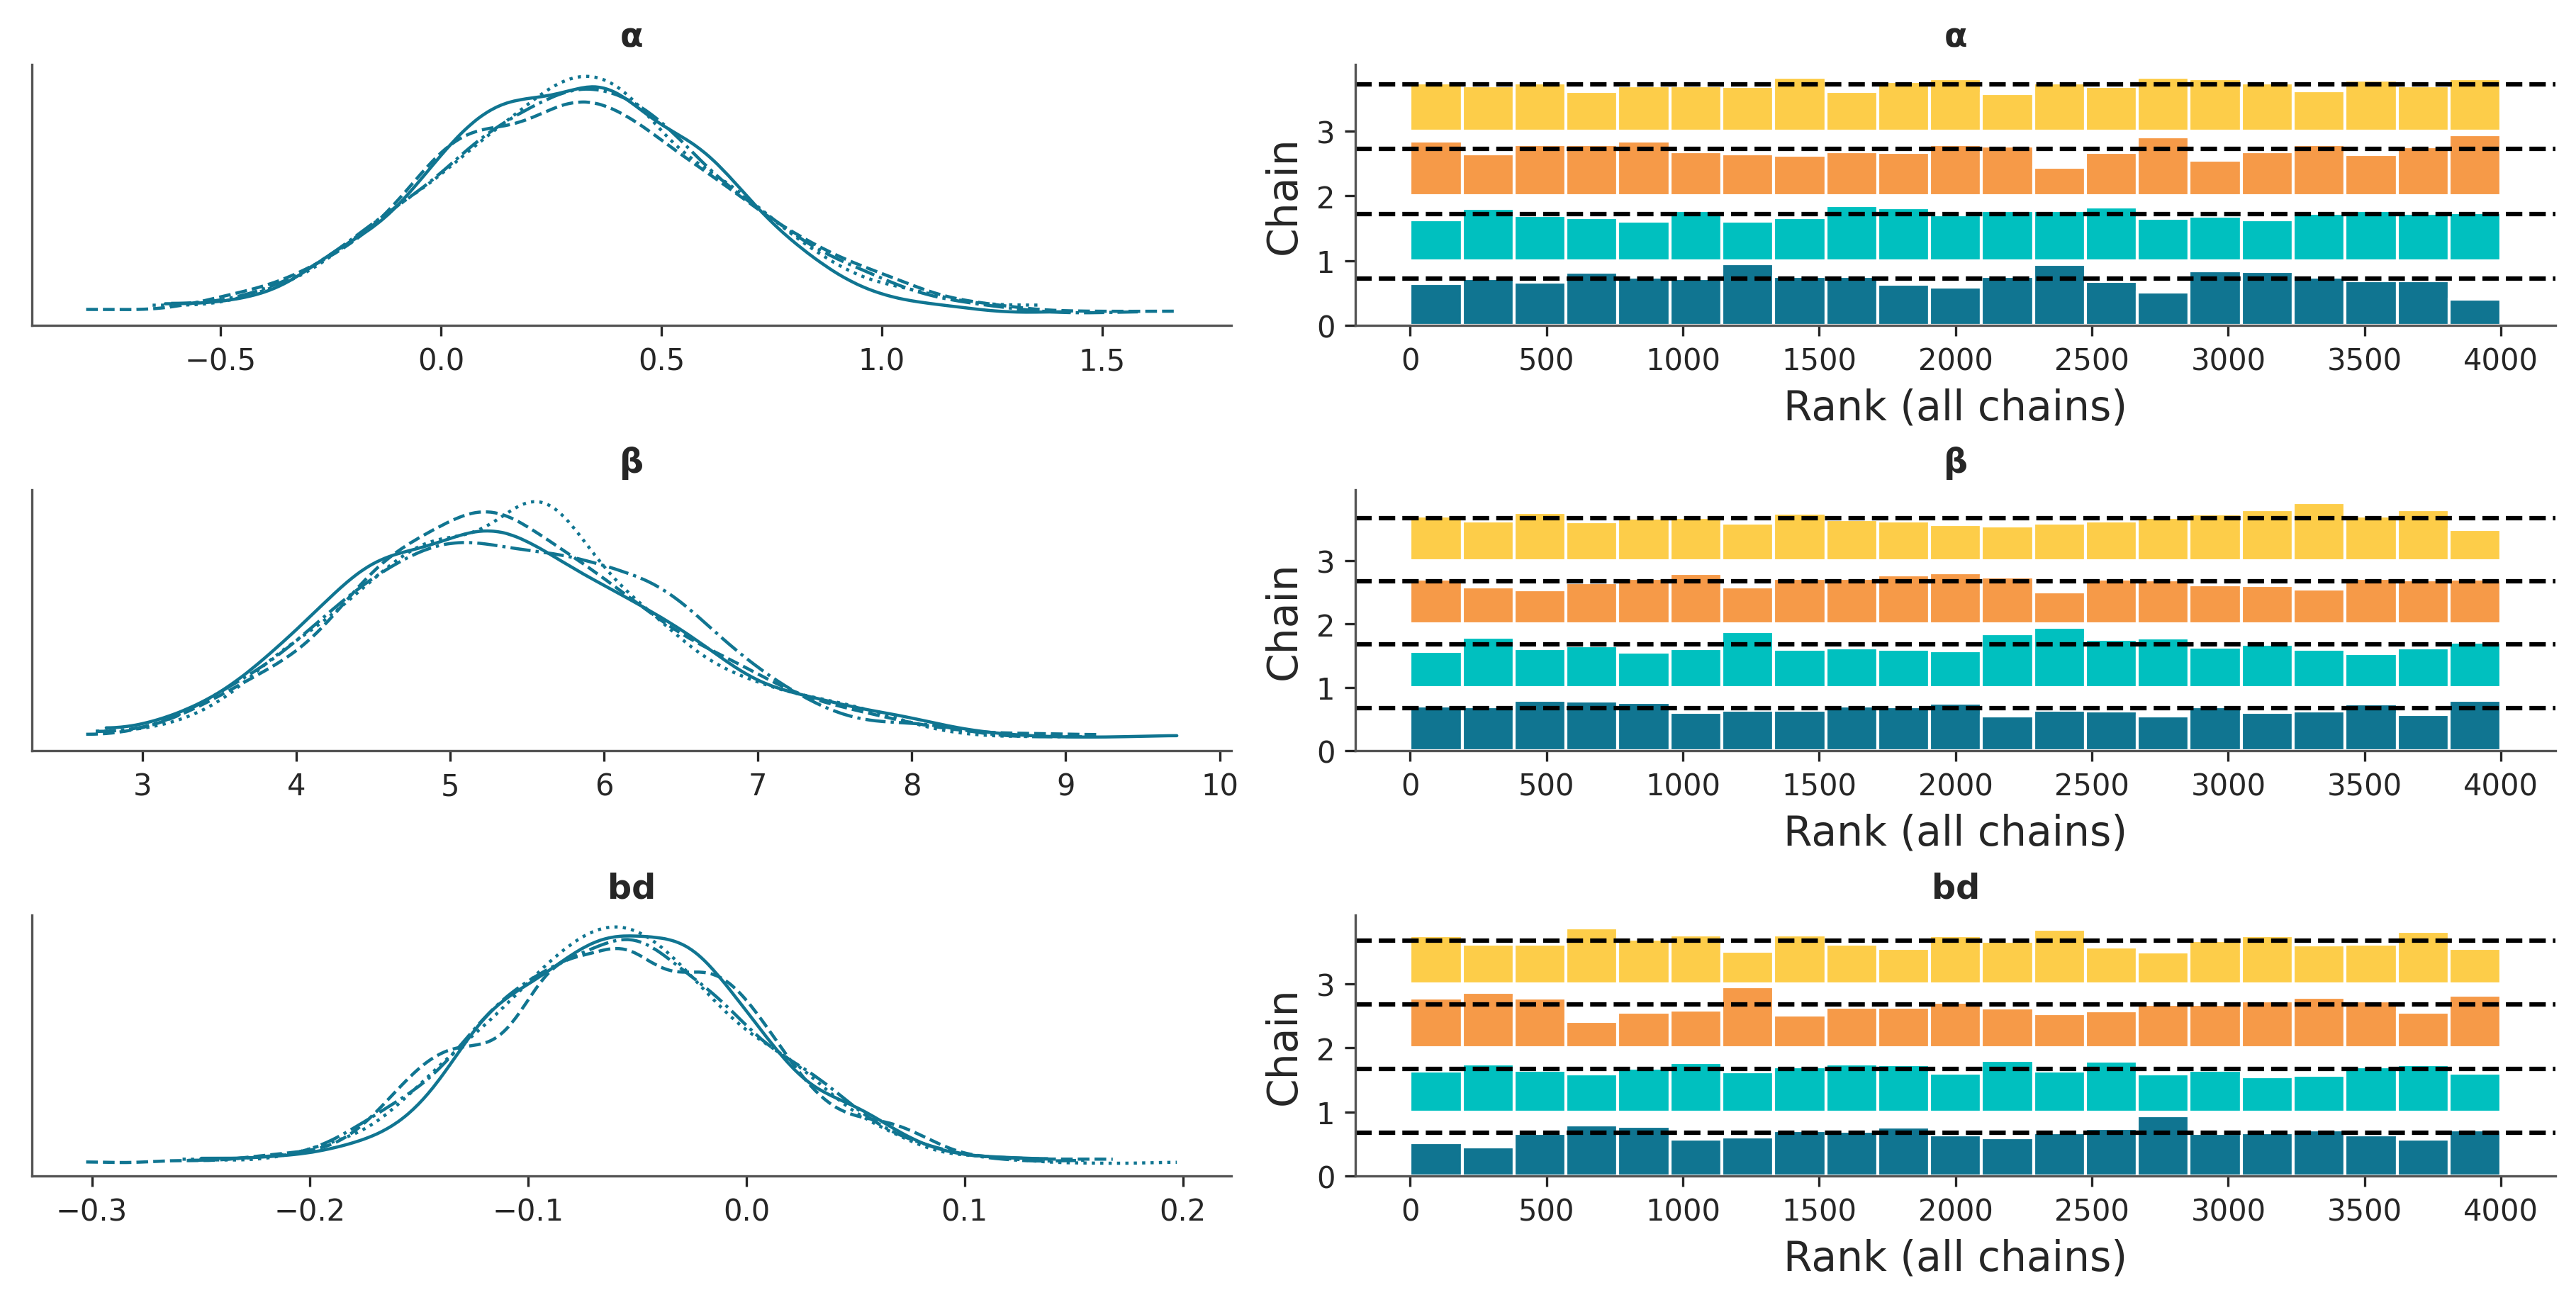

In [28]:
az.plot_trace(trace_0, var_names='~θ', kind="rank_bars");

In [29]:
az.summary(trace_0, var_names='~θ')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.312,0.337,-0.291,0.974,0.006,0.005,3320.0,2277.0,1.0
β,5.401,1.048,3.431,7.346,0.018,0.013,3219.0,2543.0,1.0
bd,-0.057,0.062,-0.161,0.071,0.001,0.001,3356.0,2533.0,1.0


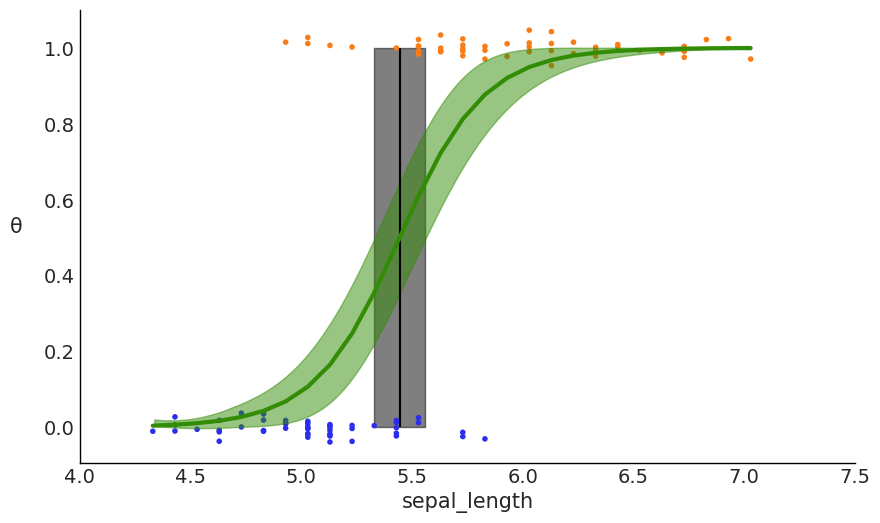

In [23]:
_, ax = plt.subplots(figsize=(10, 6))

post_0 = az.extract(idata_0)

theta = post_0['θ'].mean("sample")
idx = np.argsort(x_c)
ax.plot(x_c[idx], theta[idx], color='C8', lw=3)
ax.vlines(post_0['bd'].mean("sample"), 0, 1, color='k')
bd_hdi = az.hdi(post_0.unstack())["bd"]
ax.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

ax.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hdi = az.hdi(post_0.unstack())['θ'][idx]
ax.fill_between(x_c[idx], theta_hdi[:,0], theta_hdi[:,1], color='C8', alpha=0.5)

ax.set_xlabel(x_n)
ax.set_ylabel('θ', rotation=0, labelpad=20)
# use original scale for xticks
locs, _ = plt.xticks() 
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1));

Resumiendo los puntos más importantes hasta el momento:

* El valor de $\theta$ se corresponden con $p(y= 1 \mid x) $. En este sentido, la regresión logística es una regresión.

* Si queremos clasificar tenemos que agregar una regla para convertir esta probabilidad en una asignación de dos clases. En este caso, si $p(y = 1) >= 0.5 $ asignamos clase 1, de lo contrario clase 0.

* No hay nada especial en el valor 0.5, aparte de ser el número a mitad de camino entre 0 y 1. 

# Regresión logística múltiple

<br>

De manera similar a la regresión lineal múltiple, la regresión logística múltiple consiste en utilizar más de una variable independiente. 



In [30]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width']
#x_n = ['petal_length', 'petal_width']
x_1 = df[x_n].values

## Implementando el modelo

Para escribir el modelo de regresión logística múltiple utilizando PyMC3, aprovechamos sus capacidades de vectorización, lo que nos permite introducir solo modificaciones menores respecto del modelo logístico simple:

In [35]:
with pm.Model() as modelo_1: 
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    idata_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


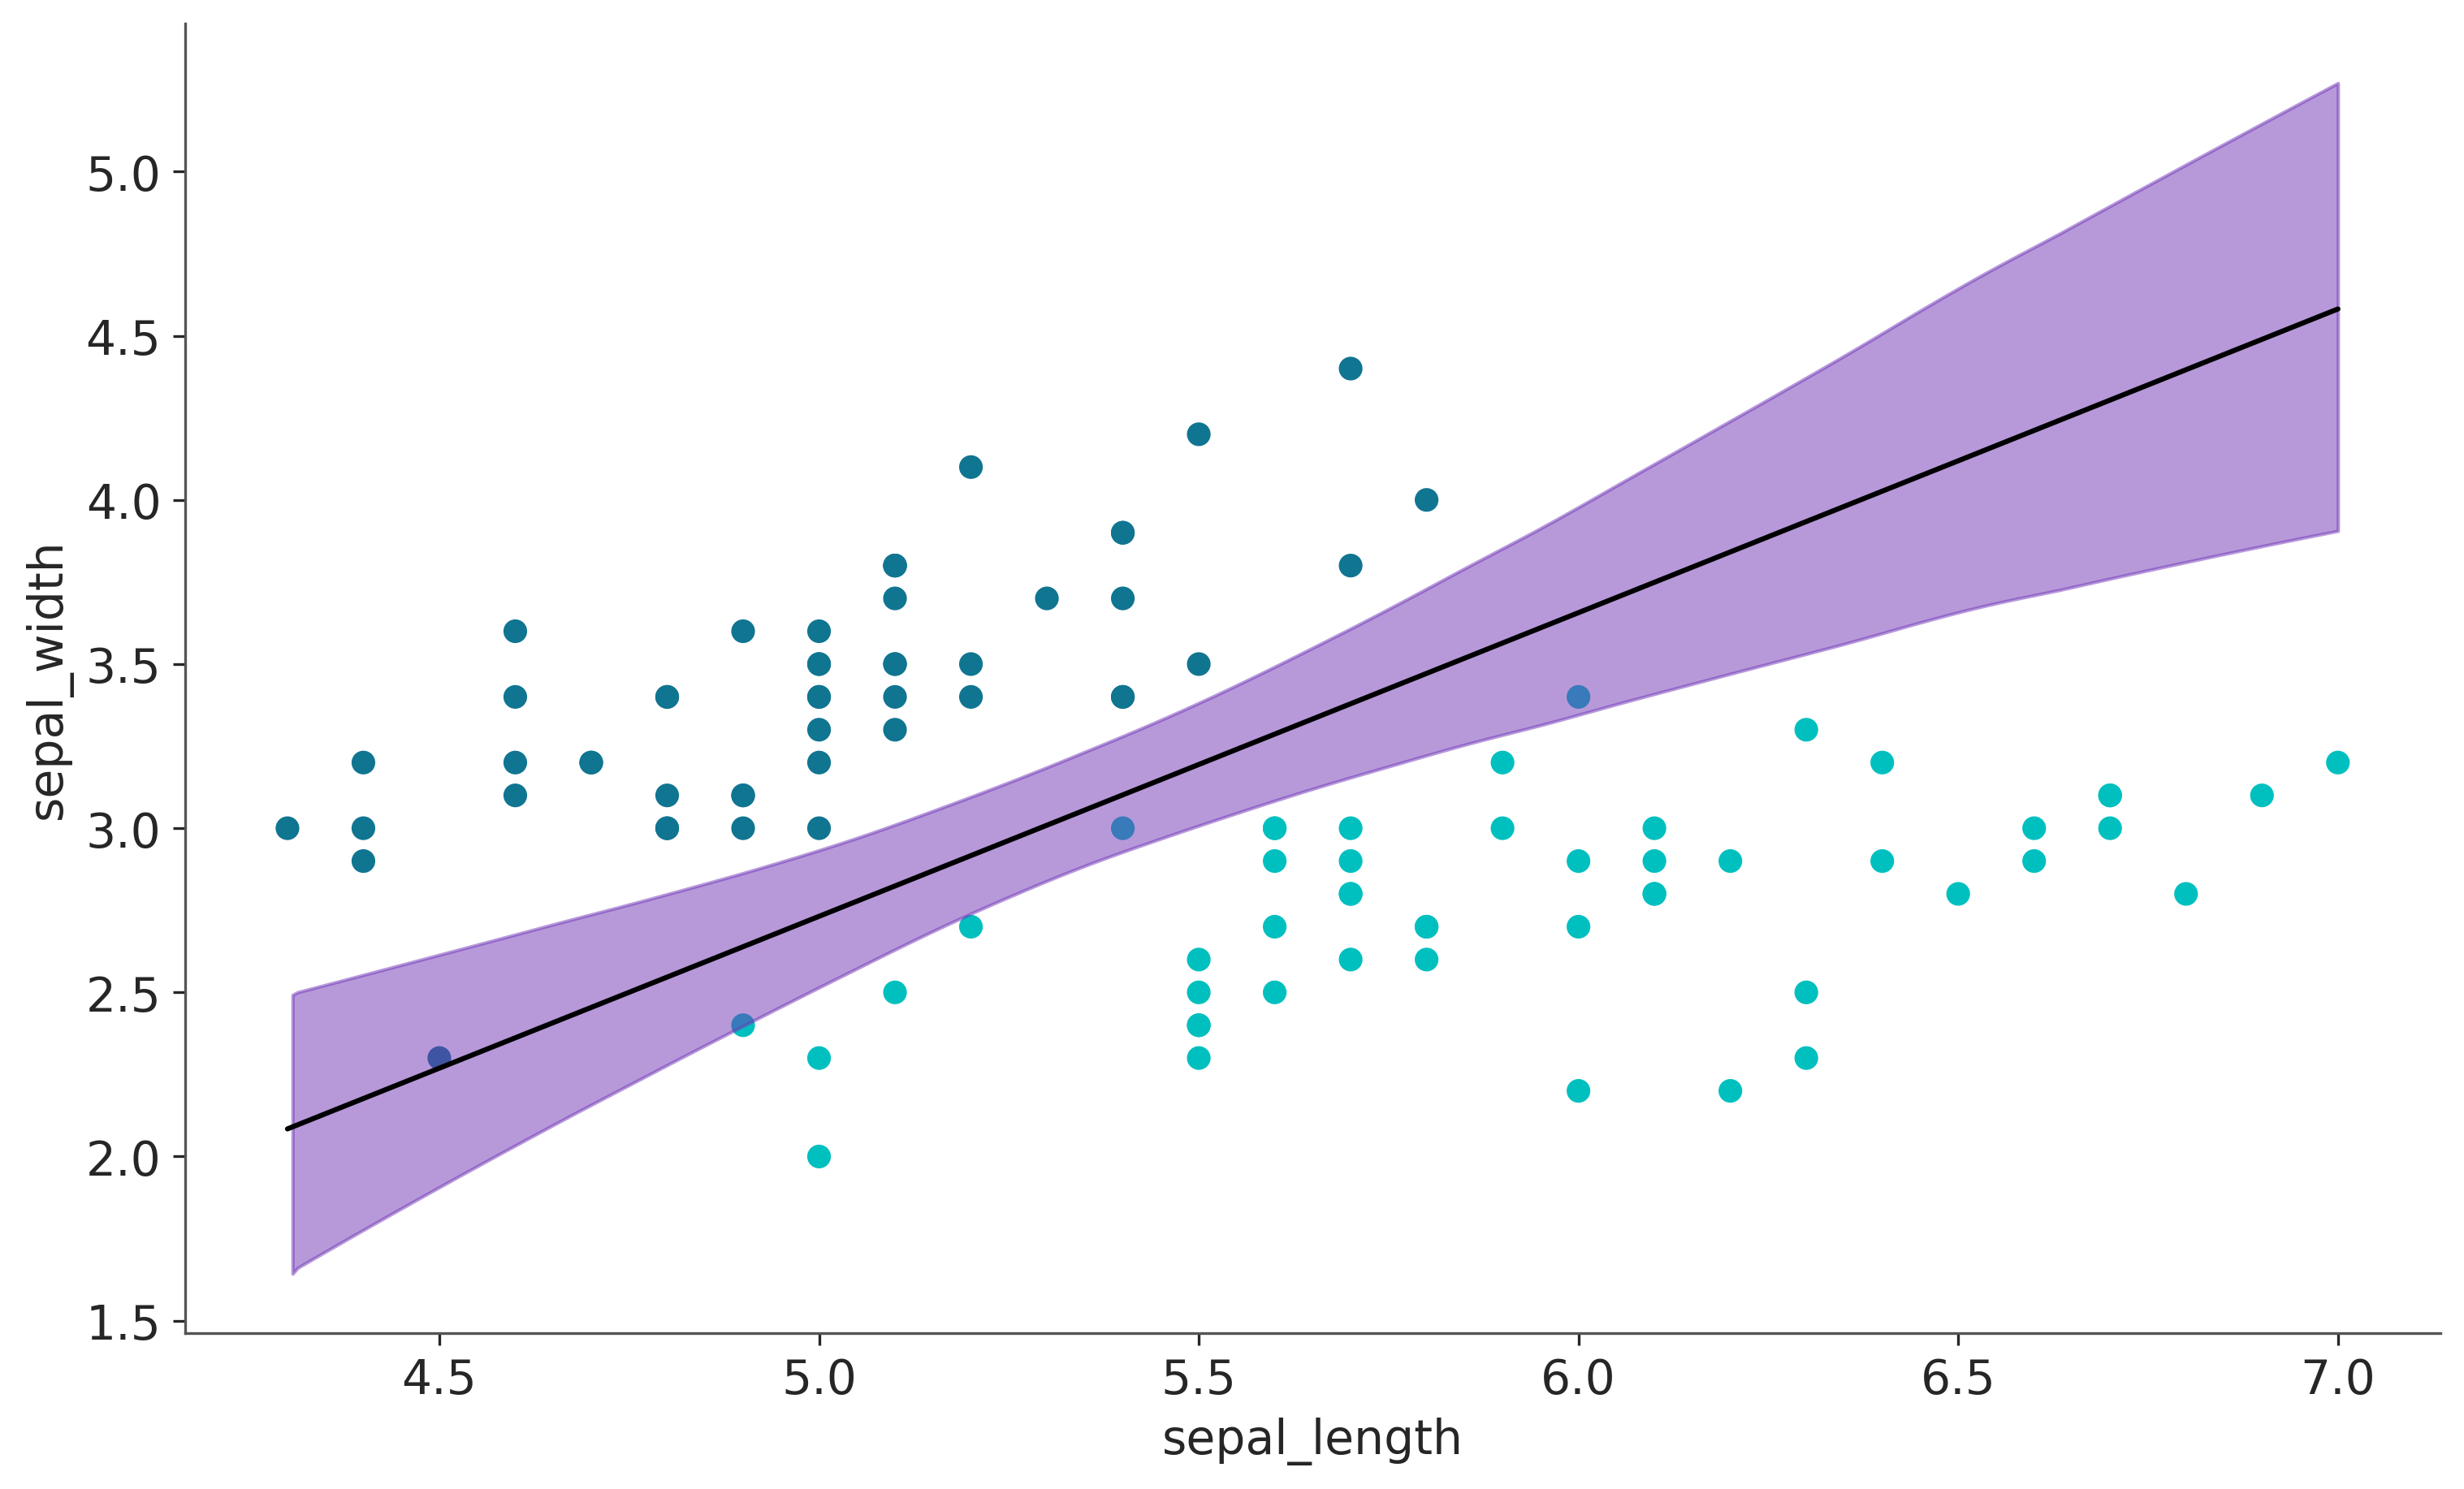

In [52]:
_, ax = plt.subplots(figsize=(10, 6))

idx = np.argsort(x_1[:,0]) 

bd = idata_1.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 
 
az.plot_hdi(x_1[:,0], idata_1.posterior['bd'], color="C8")
    
ax.set_xlabel(x_n[0]) 
ax.set_ylabel(x_n[1]);

## Interpretación de los coeficientes de una regresión logística

Debemos tener cuidado al interpretar los coeficientes $\beta$ de una regresión logística. La interpretación no es tan sencilla como con los modelos lineales en el capítulo anterior. La función logística introduce una no linearidad, que debemos tener en cuenta. Si $\beta$ es positivo, aumentar $x$ aumentará $p(y = 1)$ en cierta cantidad, pero la cantidad no es una función lineal de $x$, es en cambio una función no-lineal de $x$. Podemos visualizar este hecho en la figura 4.4, en lugar de una línea con una pendiente constante, tenemos una línea en forma de S con una pendiente que cambia en función de $x$. Un poco de álgebra nos puede dar una idea de cuánto cambia $p(y=1)$ con $\beta$:

El modelo logístico básico es:

$$\theta = logistic (\alpha + X \beta) \tag{4.11} $$

El inverso de la logística es la función logit, que es:

$$ logit(z) = log \left (\frac{z}{1-z} \right) \tag{4.12}$$

Por lo tanto, si tomamos la primera ecuación en esta sección y aplicamos la función logit a ambos términos, obtenemos:

$$ logit(\theta) = \alpha + X \beta \tag{4.13}$$

O equivalente:

$$ log \left (\frac{\theta} {1-\theta} \right) = \alpha + X \beta \tag {4.14}$$

Recuerden que $\theta$ en nuestro modelo era la probabilidad de $y = 1 $, por lo tanto:

$$ log \left(\frac {p(y = 1)} {1-p (y = 1)} \right) = \alpha + X \beta \tag {4.15} $$

La cantidad $$\frac{p (y = 1)} {1-p (y = 1)}$$ se conoce como **odds**. Los odds a favor se definen como la relación entre la probabilidad de éxito y la probabilidad de no éxito. Mientras que la probabilidad de obtener 2 tirando un dado es 1/6, los odds para el mismo evento son $\frac{1/6}{5/6} \simeq 0.2$ o dicho de otra forma 1 evento favorable frente a 5 eventos desfavorables. Los odds suelen ser utilizadas por los jugadores principalmente porque proporcionan una herramienta más intuitiva que las probabilidades _en bruto_ cuando se piensa en la forma correcta de apostar.

> En una regresión logística, el coeficiente $\beta$ codifica el aumento en unidades de log-odds por unidad de aumento de la variable $x$.

La transformación de probabilidad a odds es una transformación monotónica, lo que significa que las probabilidades aumentan a medida que aumenta la probabilidad. Mientras que las probabilidades están restringidas al intervalo $[0, 1]$, los odds viven en el intervalo $[0, \infty]$. El logaritmo es otra transformación monótonica y los log-odds están en el intervalo $[-\infty, \infty]$. La figura 4.6 muestra cómo la probabilidad está relacionada con los odds y los log-odds.

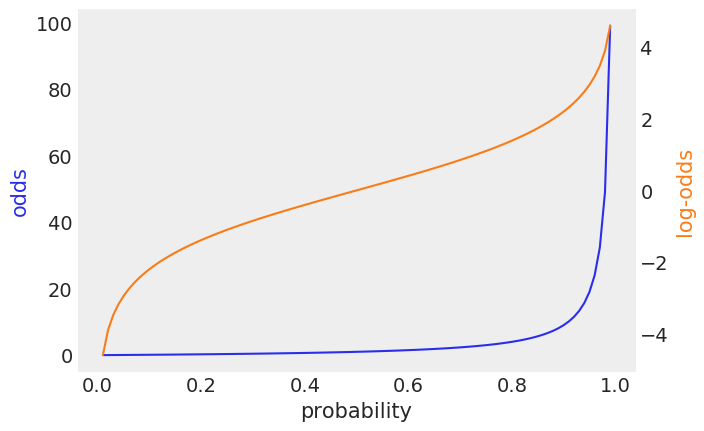

In [15]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False);

Por lo tanto, los valores de los coeficientes proporcionados por `summary` están en la escala log-odds.

In [16]:
df = az.summary(trace_1, varnames)
df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-9.046,4.622,-17.877,-0.488,0.133,0.102,1203.0,1025.0,1211.0,1071.0,1.0
β[0],4.679,0.883,3.091,6.419,0.025,0.019,1202.0,1138.0,1250.0,1152.0,1.0
β[1],-5.229,1.001,-7.040,-3.391,0.026,0.019,1485.0,1360.0,1570.0,1174.0,1.0


Una forma muy empírica de entender los modelos es cambiar los parámetros y ver qué sucede. En el siguiente bloque de código, calculamos las log-odds en favor de versicolor como $\text {log_odds_versicolor_i} = \alpha + beta_1 x1 + \beta_2 x2$, y luego la probabilidad de versicolor con la función logística. Luego repetimos el cálculo arreglando $x_2$ y aumentando $x_1$ en 1.

In [17]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

(f'{log_odds_versicolor_f - log_odds_versicolor_i:.2f}', 
 f'{probability_versicolor_f - probability_versicolor_i:.2f}')

('4.68', '0.71')

Si ejecutas el código, encontrarás que el aumento en las log-odds es de $\approx 4.7$, que es exactamente el valor de $\beta_0$ (verifique el `summary` para `trace_1`). Esto está en línea con nuestro hallazgo anterior que muestra que los coeficientes $\beta$ indican el aumento en unidades log-odds por incremento unitario de la variable $x$. El aumento en la probabilidad es $\approx 0.70$.


## How to do prior and posterior predictive checks in a multinomial-softmax regression

In chapter 4 we introduced softmax regression and showed that (see `model_sf` in the chapter) the most efficient way to model multinomial data is to artificially fix one of the predicted categories to zero (on the parameter space, not on the probability space, of course). If we don't do that, the model will be over-parametrized: since the sum of all the categories' probabilities must sum to 1, the last one is determined once we know all the other. 

What happens if we put all the categories into the model (as in `model_s` in the chapter)? Well, it is so dangerous that no one ever dared trying... Kidding aside, the model will probably run with no divergences - as NUTS is good at dealing with high correlations in the posterior. But it will be slow and inefficient. In other words, we can do better - so let's do it!

Of course, we've already done that in the chapter, so here we'll extend the example and show you how to do prior and posterior predictive checks in a multinomial-softmax regression. These are harder than usual both because of the softmax link that distorts the relation between the parameter space and the outcome space, and because all the probabilities are linked together (if one goes up, another one *must* go down). Let's dive in!

In [1]:
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
iris = sns.load_dataset("iris")

y_s = pd.Categorical(iris["species"]).codes

x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

x_s.shape, y_s.shape, np.unique(y_s)

((150, 4), (150,), array([0, 1, 2], dtype=int8))

Let's start with prior predictive checks. It's the easiest: as we'll give the same prior to all 3 categories, we need not concern ourselves with the softmax part yet. A simple logistic regression for one category and a representative range for one of the four predictors should give us a good idea of the behavior of our prior in the probability space. Here what this bad boy looks like:

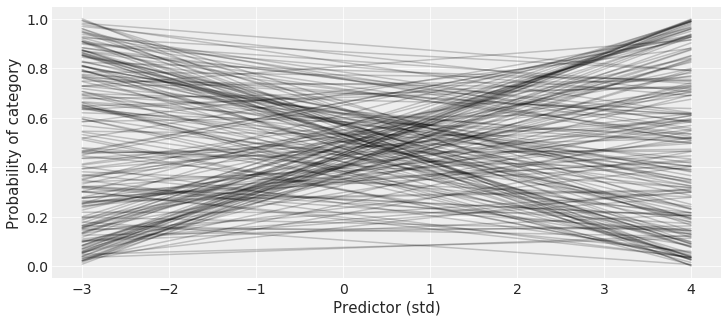

In [3]:
plt.figure(figsize=(12, 5))
a_s = pm.Normal.dist(mu=0.0, sd=1.0).random(size=200)
b_s = pm.Normal.dist(mu=0.0, sd=0.5).random(size=200)

for θ_s in zip(logistic(a_s - 3 * b_s), logistic(a_s + 4 * b_s)):
    plt.plot([-3, 4], θ_s, color="k", alpha=0.2)

plt.xlabel("Predictor (std)")
plt.ylabel("Probability of category");

What do these priors say - apart from paying a hidden tribute to the X-men? We can say they are "weakly regularizing" priors, because they bound the lines to possible ranges of the variables, while still allowing some implausibly strong relationships.

We could maybe regularize even more - in fact I encourage you to change the priors for `a_s` and `b_s` above to see the consequences on the outcome space - but these priors should allow smooth sampling of the model:

In [4]:
with pm.Model() as model_sf:
    α = pm.Normal("α", mu=0.0, sd=1.0, shape=2)
    α_f = tt.concatenate([[0], α])

    β = pm.Normal("β", mu=0.0, sd=0.5, shape=(4, 2))
    β_f = tt.concatenate([np.zeros((4, 1)), β], axis=1)

    X = pm.Data("X", x_s)
    μ = α_f + pm.math.dot(X, β_f)
    θ = pm.Deterministic("θ", tt.nnet.softmax(μ))

    yl = pm.Categorical("yl", p=θ, observed=y_s)

    trace_sf = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_sf, round_to=2, var_names=["α", "β"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:37<00:00, 159.98draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],0.86,0.32,0.26,1.45,0.01,0.01,2040.74,1949.57,2043.08,1290.38,1.0
α[1],-0.40,0.45,-1.25,0.41,0.01,0.01,2078.15,1643.39,2079.00,1689.96,1.0
"β[0,0]",0.78,0.34,0.14,1.40,0.01,0.01,1507.99,1419.97,1504.05,1342.31,1.0
"β[0,1]",0.85,0.36,0.20,1.51,0.01,0.01,1690.25,1548.60,1696.44,1557.86,1.0
"β[1,0]",-1.04,0.27,-1.53,-0.53,0.01,0.00,2312.29,2162.90,2327.35,1463.43,1.0
"β[1,1]",-0.58,0.33,-1.17,0.04,0.01,0.01,2302.81,1920.29,2306.19,1620.59,1.0
"β[2,0]",0.81,0.38,0.11,1.51,0.01,0.01,1953.75,1664.09,1970.73,1520.09,1.0
"β[2,1]",1.62,0.44,0.84,2.48,0.01,0.01,1667.52,1667.52,1664.72,1188.90,1.0
"β[3,0]",0.30,0.37,-0.40,0.97,0.01,0.01,1755.85,1455.68,1764.94,1328.86,1.0
"β[3,1]",1.98,0.40,1.24,2.74,0.01,0.01,1742.11,1731.07,1735.90,1478.57,1.0


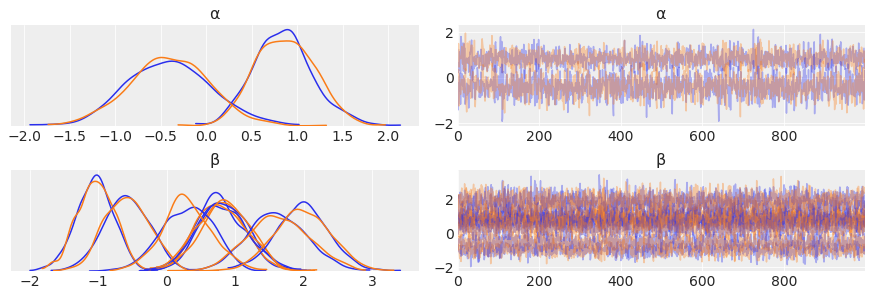

In [5]:
az.plot_trace(trace_sf, var_names=["α", "β"], compact=True);

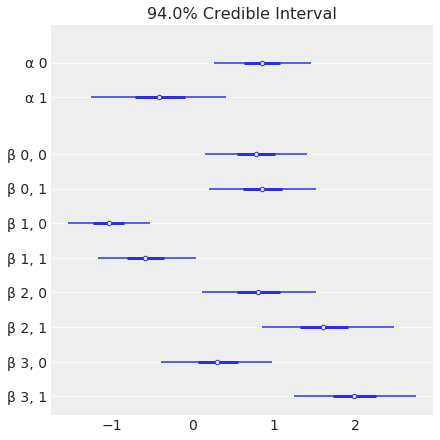

In [6]:
fig, axes = az.plot_forest(trace_sf, var_names=["α", "β"], combined=True)
axes[0].grid();

Everything looks fine. Now let's tackle what we came for: posterior predictive checks! We'll draw two types of PPC here, starting by what Richard McElreath calls "counterfactual plots". These show how predictions change when only one predictor varies and other predictors are held constant.

So, in the function below, only one predictor of interest (`mobile_pred`) is allowed to vary across a wide range of values ([-3, 4]), while the other three predictors are held constant at 0 (their mean value - remember, they are standardized). We then sample posterior predictive probabilities from the model, with these new `X` values. This means we get 500 samples for each category's probability under the new counterfactual conditions. The plots then display the change in probability across values of the predictor of interest and... tadaaaa!

In [7]:
def counterfact_plots(mobile_pred: str):
    """
    Plots the change in each category's predicted probability across values of a single predictor, 
    holding the other predictors constant at 0 (their mean value, as they are standardized).
    Shaded regions show 94% compatibililty intervals of the probabilities.
    mobile_pred: name of one of the four predictors contained in array x_n. This predictor is then
    allowed to vary from -3 to 4, which represents quite a wide range as the predictors are std.
    """
    # hold predictors at 0, except for mobile_pred:
    idx_pred = np.where(x_n == mobile_pred)[0][0]
    l, h = np.zeros(len(x_n)), np.zeros(len(x_n))
    l[idx_pred], h[idx_pred] = -3, 4
    predictor_seq = np.linspace(l, h)

    # compute counterfactual probabilities (θ):
    with model_sf:
        pm.set_data({"X": predictor_seq})
        post_checks = pm.sample_posterior_predictive(
            trace_sf, var_names=["θ"], random_seed=RANDOM_SEED
        )["θ"]
    θ_mean = post_checks.mean(0)

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    i = 0
    for ax in axes:
        ax.plot(predictor_seq[:, idx_pred], θ_mean[:, i])
        az.plot_hpd(predictor_seq[:, idx_pred], post_checks[:, :, i], ax=ax)
        ax.set_ylim([0, 1])
        ax.set_xlabel(f"{mobile_pred} (std)")
        ax.set_ylabel(f"Probability of {iris.species.unique()[i]}")
        ax.set_title("Other predictors (std) = 0")
        i += 1

100%|██████████| 2000/2000 [00:01<00:00, 1312.91it/s]


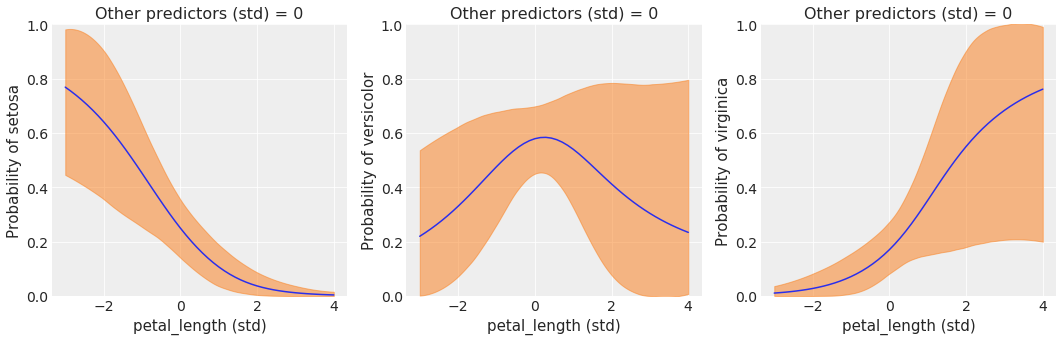

In [8]:
counterfact_plots("petal_length")

Pretty neat, uh?! These plots help us understand the model's implications, which is hugely valuable when your model has several predictors and dimensions. Keep in mind though that these predictons are *counterfactual*: they display predictions for impossible combinations of predictor values - in the real world, it's probably very difficult to vary petal length without affecting petal width for instance.

These plots are lacking one type of information however: they don't compare the model's predictions against raw data. Let's do that, now that we have a better understanding of the posterior distribution. The idea is to plot predictions against observed data, to see if the model correctly approximates the posterior distribution, and where the model fails. That's what the appropriately named "posterior predictive plots" do.

Before that though, let's compute what percentage of predictions we got right, to get a sense of whether the model's predictions fit the raw data:

In [9]:
θ_pred = trace_sf["θ"].mean(0)
f"{np.mean(y_s == np.argmax(θ_pred, axis=1)):.2f}"

'0.94'

So, on average, we associated each point to its real category 94% of the time - pretty good! Remember though that we're not aiming for 100% accuracy here: this would reflect over-fitting, as we're talking about in-sample predictions here. Our regularizing priors from the beggining are precisely here to help with that: they tend to reduce in-sample fit to improve out-of-sample predictions.

That being said, let's visually compare our predictions against the raw data. First, let's set the predictors back to their original values and generate posterior predictive samples:

In [10]:
with model_sf:
    pm.set_data({"X": x_s})
    post_checks = pm.sample_posterior_predictive(trace_sf, random_seed=RANDOM_SEED)

100%|██████████| 2000/2000 [00:28<00:00, 71.23it/s]


As it turns out, ArviZ has a very convenient function to plot PPCs:

/anaconda/envs/fund/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/anaconda/envs/fund/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


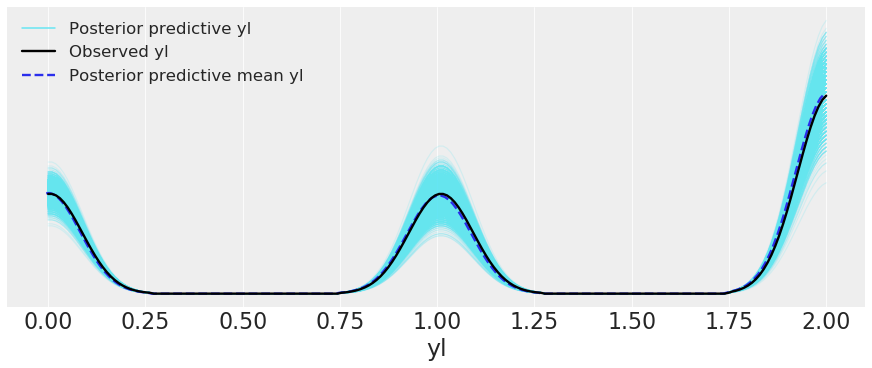

In [11]:
idata = az.from_pymc3(trace=trace_sf, posterior_predictive=post_checks)
az.plot_ppc(idata, random_seed=RANDOM_SEED, figsize=(12, 5));

A note before going on: this plot uses KDEs (which assumes a continuous distribution) for a categorical distribution (which is discrete). That is why you see 3 bumps at 0, 1 and 2 (the only three values that `yl` can take) and a density of 0 for all other `yl` values. You're probably used to seeing these graphs with histograms. We can't do that with `az.plot_ppc`, but here it's quite easy to understand both the plot and the discretness of the distribution. Still curious? Try passing `kind="cumulative"` or `kind="scatter"` to `az.plot_ppc` and see what comes up...

But what is this plot telling us? That the model did a very good job at approximating the posterior distribution, basically - the 3 curves are a perfect match for each other. But this plot doesn't tell us where the model fails. To see that, we have to plot the individual data points:

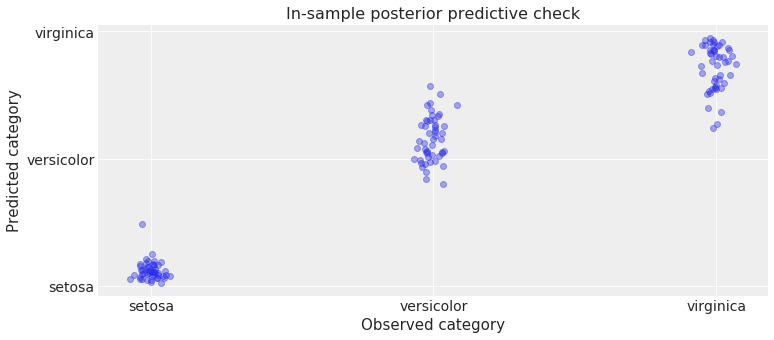

In [12]:
y_pred = post_checks["yl"].mean(0)
jitter = np.random.normal(0, 0.03, len(y_s))

plt.figure(figsize=(12, 5))
plt.scatter(y_s + jitter, y_pred, alpha=0.4)
plt.xticks(range(3), iris.species.unique())
plt.xlabel("Observed category")
plt.yticks(range(3), iris.species.unique())
plt.ylabel("Predicted category")
plt.title("In-sample posterior predictive check");

We see that the model does a very good job at predicting setosa flowers, but seems to have trouble differentiating versicolor from virginica - it regularly mixes up one for the other. This suggests that these two species are close regarding the features we included into the model. If we had a finer view of what tells them apart, we could get this information into the model and improve our predictions - and understanding. How do we do that? Well, we're no botanists, so that's where domain knowledge comes into play.

More generally, this notebook focused on how to inspect the gut of your model for not-so-simple models, like mutinomial regressions. But we did not think causally here to determine which predictors to regress on. That's ok for a notebook that aims to give a technical view, but if you want to go beyond mere predictions - e.g understanding the process and intervening in the real world based on your model's insights - then you'll need a causal graph before doing any modeling.

You're still there? Well, thanks for reading! As we are (still) mere mortals, we may have forgotten about important aspects or made mistakes - so please, send your pull requests our way on this repo. And above all, live long & PyMCheers!

In [13]:
%watermark -a AlexAndorra -n -u -v -iv -w

arviz      0.5.1
theano     1.0.4
seaborn    0.9.0
pandas     0.25.1
matplotlib 3.1.1
numpy      1.16.5
pymc3      3.7
AlexAndorra 
last updated: Thu Oct 17 2019 

CPython 3.7.4
IPython 7.8.0
watermark 2.0.1


## Regresión de Poisson

Otro modelo lineal generalizado muy popular es la regresión de Poisson. Este modelo asume que los datos se distribuyen de acuerdo con la distribución de Poisson.

Un escenario en el que la distribución de Poisson es útil es cuando se analizan cosas, como la descomposición de un núcleo radioactivo, el número de hijos por pareja o el número de seguidores de Twitter. Lo que todos estos ejemplos tienen en común es que usualmente los modelamos usando números discretos no negativos {0, 1, 2, 3 ...}. Este tipo de variable recibe el nombre de datos de conteo (count data).

### La distribución de Poisson

Imagina que estamos contando la cantidad de autos rojos que pasan por una avenida por hora. Podríamos usar la distribución de Poisson para describir estos datos. La distribución de Poisson se utiliza generalmente para describir la probabilidad que ocurra un número determinado de eventos independientes entre si en un intervalo de tiempo o espacio fijo. Esta distribución discreta se parametriza utilizando solo un valor, $\mu$ (la tasa, también comúnmente representada con la letra griega $\lambda$). $\mu$ corresponde a la media y también a la varianza de la distribución. La función de probabilidad de masa de la distribución de Poisson es:

$$ f(x \mid \mu) = \frac {e^{-\mu}\mu^x} {x!} \tag{4.17}$$

dónde:
* $\mu$ es el número promedio de eventos por unidad de tiempo / espacio
* $x$ es un valor entero positivo 0, 1, 2, ...
* $x!$ es el factorial de x, k! = k × (k - 1) × (k - 2) × ... × 2 × 1

En la siguiente gráfica, podemos ver algunos ejemplos de la familia de distribución de Poisson, para diferentes valores de $\mu$.

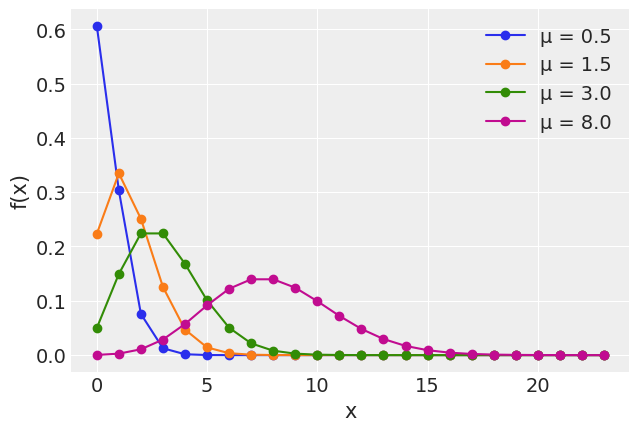

In [31]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)');

Los modelos lineales son muy comunes y son una familia más extensa que la vista hasta ahora (como veremos en el próximo capítulo). Por esa razón, PyMC3 incluye un módulo que simplifica la creación de modelos lineales generalizados (el nombre quedará claro en el próximo capítulo). Por ejemplo, una regresión lineal simple se puede especificar como:

```python
with pm.Model () as modelo:
    glm.glm ('y ~ x', datos)
    trace = sample (2000)
```

La segunda línea del código anterior se ocupa de agregar priors (planos XXXX !!!!!) predeterminados para la intersección y para la pendiente y una Gaussiana como _likelihood_. Lo cual está bien si solo desea ejecutar una regresión lineal predeterminada. Tenga en cuenta que el MAP de este modelo será esencialmente equivalente al obtenido utilizando el método (frecuentista) de mínimos cuadrados. De ser necesario, también es posible usar el módulo glm y cambiar los _a prioris_ y el _likelihood_. La sintaxis está tomada de paquetes de R, donde 'y ~ x' especifica que tenemos una variable $y$ que queremos estimar como una función lineal de $x$. 

Es importante notar que $\mu$ puede ser un flotante, pero la distribución modela probabilidad de un número discreto de eventos. En la figura 4.10, los puntos representan los valores de la distribución, mientras que las líneas continuas son una ayuda visual que nos ayuda a comprender fácilmente la _forma_ de la distribución. Recuerde, la distribución de Poisson es una distribución discreta.

La distribución de Poisson puede verse como un caso especial de la distribución binomial cuando la cantidad de intentos $n$ es muy grande pero la probabilidad de éxito $p$ es muy baja. Sin entrar en detalles matemáticos, tratemos de aclarar la afirmación anterior. Siguiendo el ejemplo del auto, podemos afirmar que o vemos el auto rojo o no, por lo que podemos usar una distribución binomial. En ese caso tenemos:

$$ x \sim Bin(n, p) \tag{4.18}$$

Entonces, la media de la distribución binomial es:

$$\mathbf{E}[x] = np \tag{4.19} $$

Y la varianza viene dada por:

$$ \mathbf {V}[x] = np (1 - p) \tag{4.20}$$

Pero tenga en cuenta que incluso si se encuentra en una avenida muy transitada, la posibilidad de ver un auto rojo en comparación con el número total de automóviles en una ciudad es muy pequeño y, por lo tanto, tenemos:

$$n >> p \Rightarrow np \simeq np (1-p) \tag{4.21}$$

Entonces, podemos hacer la siguiente aproximación:

$$\mathbf {V}[x] = np \tag{4.22}$$

Ahora la media y la varianza están representadas por el mismo número y podemos
declarar con confianza que nuestra variable se distribuye como una distribución de Poisson:

$$x \sim Poisson(\mu = np) \tag{4.23}$$

## El modelo de Poisson inflado de ceros

Al contar cosas, una posibilidad es no contar esas cosas, es decir obtener cero. El número cero puede ocurrir generalmente por muchas razones; obtuvimos un cero porque estábamos contando autos rojos y un auto rojo no pasó por la avenida o porque no logramos verlo (tal vez no vimos pasar un diminuto auto rojo detrás de un gran camión). Entonces, si usamos una distribución de Poisson, notaremos, por ejemplo, cuando realizamos una verificación predictiva posterior, que el modelo generó menos ceros en comparación con los datos.

¿Cómo arreglamos eso? Podemos tratar de abordar la causa exacta por la cual nuestro modelo predice menos ceros de los observados e incluir ese factor en el modelo. Sin embargo, suele ser el caso, que es suficiente y más fácil para nuestro propósito, asumir que simplemente tenemos una mezcla de dos procesos:

* Uno modelado por una distribución de Poisson con probabilidad $\psi$
* Otra persona que da ceros adicionales con probabilidad $1 - \psi$.

Esto se conoce como modelo Poisson inflado de ceros (ZeroInflatedPoisson). En algunos textos, encontrarás que $\psi$ se usa para representar los ceros extra y $1-\psi$ la probabilidad de Poisson.

Básicamente una distribución ZIP nos dice que:

$$p(y_j = 0) = 1 - \psi + (\psi) e^{-\mu} \tag{4.24}$$

$$p(y_j = k_i ) = \psi \frac{\mu^x_i e^{-\mu}}{x_i!} \tag{4.25}$$ 

Donde $1-\psi$ es la probabilidad de ceros adicionales. Podríamos implementar fácilmente estas ecuaciones en un modelo PyMC3. Sin embargo, podemos hacer algo aún más fácil y usar la distribución ZIP de PyMC3.

In [32]:
#np.random.seed(42)
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * np.random.poisson(θ_real)
                   for i in range(n)])

In [33]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1., 1.)
    θ = pm.Gamma('θ', 2., 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ, observed=counts)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, ψ]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 1917.99draws/s]


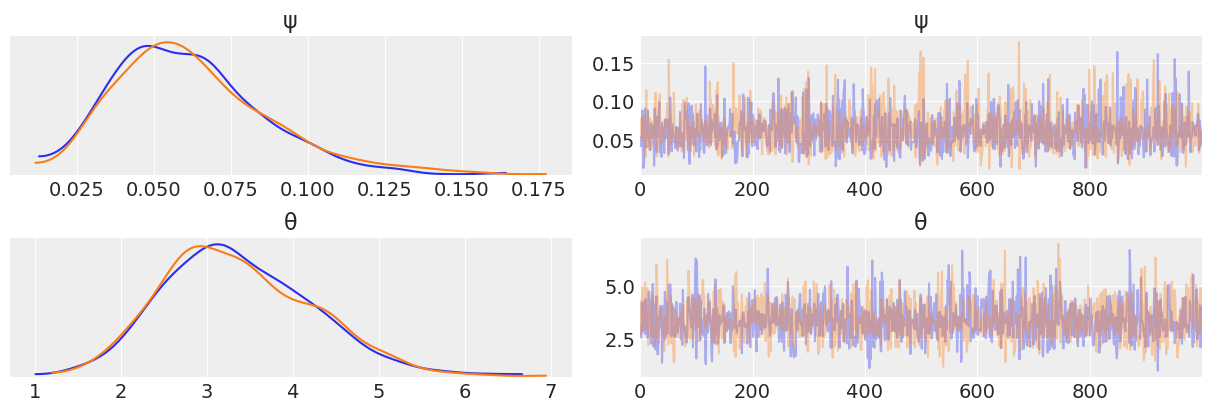

In [34]:
az.plot_trace(trace);

In [35]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ψ,0.062,0.025,0.023,0.111,0.001,0.000,1977.0,1879.0,1948.0,1384.0,1.0
θ,3.378,0.883,1.880,5.078,0.021,0.015,1733.0,1680.0,1711.0,1175.0,1.0


## Regresión de Poisson y regresión ZIP

El modelo ZIP puede parecer un poco aburrido, pero a veces necesitamos estimar distribuciones simples como esta u otra como las distribuciones de Poisson o Gaussianas. Además, podemos usar las distribuciones Poisson o ZIP como parte de un modelo lineal. Como vimos con la regresión logística (y softmax) podemos usar una función de enlace inverso para transformar el resultado de un modelo lineal en una variable adecuada para ser utilizada con otra distribución que no sea la normal. En la siguiente figura, vemos una posible implementación de una regresión ZIP. La regresión de Poisson será similar, pero sin la necesidad de incluir $\phi$ ya que no modelaremos un exceso de ceros. Observe que ahora usamos la función exponencial como la función de enlace inverso. Esta elección garantiza que los valores devueltos por el modelo lineal sean positivos.

Para ejemplificar la implementación de un modelo de regresión ZIP, vamos a trabajar con un conjunto de datos tomado del [Instituto de Investigación y Educación Digital](http://www.ats.ucla.edu/stat/data).

El problema es el siguiente: trabajamos en la administración de un parque y queremos mejorar la experiencia de los visitantes. Por lo tanto, decidimos realizar una breve encuesta a 250 grupos que visitan el parque. Parte de los datos que recopilamos (a nivel de grupo) consiste en:

* La cantidad de peces que capturaron (contar)
* Cuántos niños había en el grupo (niño)
* Ya sea que hayan traído o no una casa-rodante o "caravana" al parque (camper).

Usando estos datos, vamos a construir un modelo que predice el número de peces capturados en función de las variables niño y caravana. Podemos usar Pandas para cargar los datos:

In [36]:
fish_data = pd.read_csv('datos/fish.csv')

Lo dejo como un ejercicio para que explore el conjunto de datos utilizando gráficos y / o una función de Pandas, como `describe()`. Por ahora vamos a continuar traduciendo el diagrama de Kruschke anterior a PyMC3:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, ψ]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 613.66draws/s]


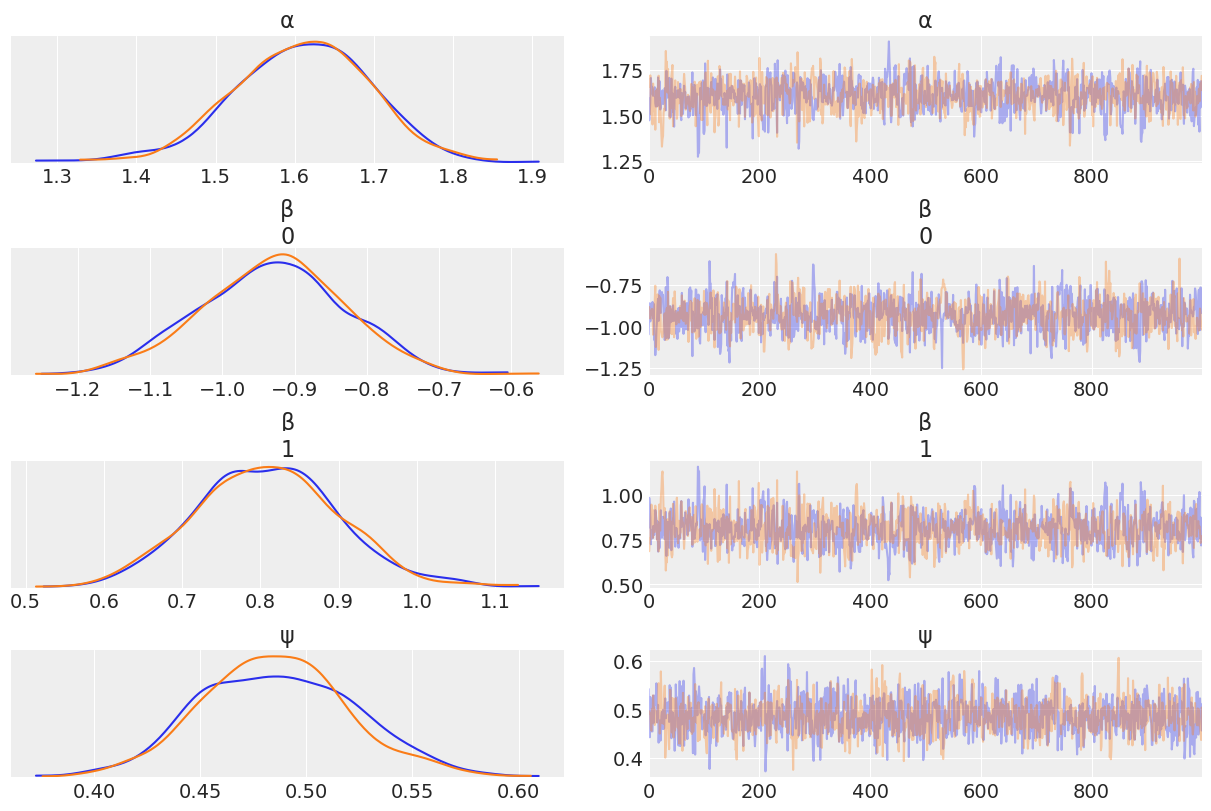

In [37]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(1000)
az.plot_trace(trace_ZIP_reg);

Para entender mejor los resultados de nuestra inferencia, hagamos una gráfica.

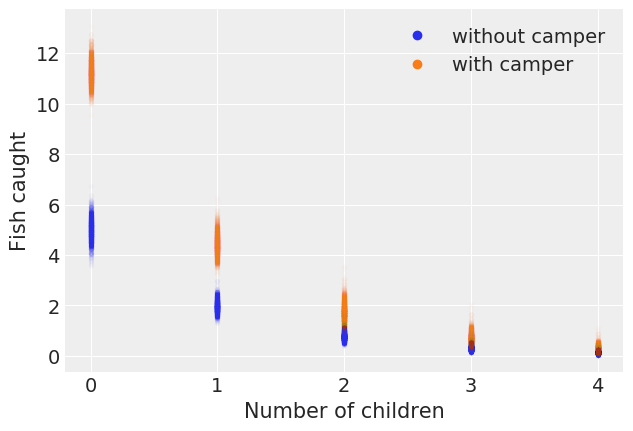

In [38]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
for n in children:
    without_camper = trace_ZIP_reg['α'] + trace_ZIP_reg['β'][:,0] * n
    with_camper = without_camper + trace_ZIP_reg['β'][:,1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend();